In [28]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss, TverskyLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
from hybrid_model_v3 import HybridSegModel

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [5]:
import wandb
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: s960068sss (s960068sss-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tx
import random
import cv2
from PIL import ImageEnhance
from skimage.exposure import match_histograms
import torchvision.transforms as T
import torchvision.transforms.functional as F
class GE_Thyroid_Dataset(Dataset):
    def __init__(self, csv_file, transform, image_size):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.image_size = image_size
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df["image_name"][idx]
        mask_name = self.df["mask_name"][idx]
        image_type = self.df["image_type"][idx]

        if image_type == "train":
            from_folder = "../ge_data/train"
        else:
            from_folder = "../ge_data/test"
        
        image_path = f"{from_folder}/images/{image_name}"
        mask_path = f"{from_folder}/masks/{mask_name}"

        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        image_tensor, mask_tensor = self.transform(image, mask, self.image_size)
        mask_tensor = (mask_tensor > 0.5).float()
        if torch.sum(mask_tensor) == 0:
            # print("nothing")
            return [None]
        return image_tensor, mask_tensor, mask_name, image_type

In [20]:
image_size = 128
batch_size = 128
def train_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    p = 0.7
    
    # if(random.random() < p):
    #     jitter = T.ColorJitter(brightness = 0.5, contrast = 0.25)
    #     image = jitter(image)
    # if(random.random() < p):
    #     transform = T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    #     image = transform(image)  # image must be a PIL image
    if(random.random() < p):
        # angle = random.uniform(-10, 10)  # 旋轉角度從 ±10 度
        angle = 0.0
        max_dx = 0.05  # 水平平移比例
        max_dy = 0.3  # 垂直平移比例
        translate_x = random.uniform(-max_dx, max_dx) * image.size[0]
        translate_y = random.uniform(-max_dy, max_dy) * image.size[1]
        translate = (int(translate_x), int(translate_y))
        scale = random.uniform(0.9, 1.6)  # 尺度縮放 ±5%
        # scale = 1.0
        # shear = [random.uniform(-5, 5), random.uniform(-5, 5)]  # 小幅剪切
        shear=[0.0, 0.0]
        image = F.affine(image, angle=angle, translate=translate, scale=scale, shear=shear)
        mask = F.affine(mask, angle=angle, translate=translate, scale=scale, shear=shear)

        
    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def custom_collate_fn(batch):
    # print(batch)
    filtered_batch = [item for item in batch if item[0] is not None]
    if len(filtered_batch) == 0:
        return None
    return torch.utils.data.dataloader.default_collate(filtered_batch)
train_dataset = GE_Thyroid_Dataset("../ge_data/train_csv_for_finetune(0.3).csv", transform = train_augmentation, image_size = image_size)
# train_dataset = GE_Thyroid_Dataset("../ge_data/test_csv_for_finetune_all.csv", transform = train_augmentation, image_size = image_size)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn=custom_collate_fn)

test_dataset = GE_Thyroid_Dataset("../ge_data/test_csv_for_finetune_all.csv", transform = test_augmentation, image_size = image_size)
# test_dataset = GE_Thyroid_Dataset("../ge_data/train_csv_for_finetune(0.3).csv", transform = test_augmentation, image_size = image_size)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, collate_fn=custom_collate_fn)

image, mask, mask_name, image_type = next(iter(test_dataloader))

In [21]:
image.shape

torch.Size([101, 1, 128, 128])

In [22]:
print(len(train_dataset), len(test_dataset))

169 112


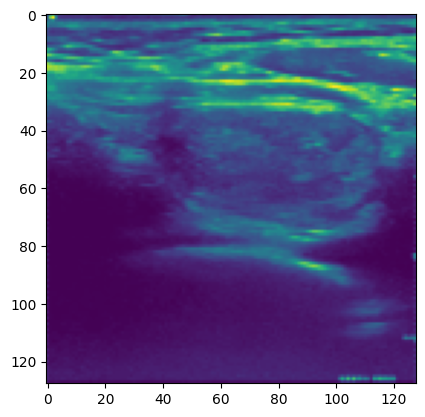

In [23]:
plt.imshow(image[18][0])

In [24]:

# inference_name = "hybrid_v3_baseline"

# model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
# checkpoint = torch.load(f"models/{inference_name}/best_checkpoint.pth")
# model.load_state_dict(checkpoint['model_state_dict'])
# loss_fn = StructureLoss()
# optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
# lr = 0.01
# model.to("cuda")
# image = image.to("cuda")
# mask = mask.to("cuda")
# for epoch in range(200):
#     outputs = model(image)
        
#     output = outputs[:, 0:1, :, :]
    
    
#     loss = loss_fn(output, mask)

#     IOU = IOU_score(output, mask)

#     dice_loss = DiceLoss()
#     DICE = 1 - dice_loss(output, mask)

    
#     # Backward and optimize
#     optimizer.zero_grad()   # clear previous gradients
#     loss.backward()         # compute gradients
#     optimizer.step()        # update weights
#     print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, IOU: {IOU.item():.4f}, DICE: {DICE.item()}")

In [25]:
def train(dataloader, model, optimizer, loss_fn, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0
    
    model.train()
    model.to(device)
    count = 0
    for image, mask, mask_name, image_type in tqdm(dataloader):
        image, mask = image.to(device), mask.to(device)
        
        outputs = model(image)
        
        output = outputs[:, 0:1, :, :]
        
        
        loss = loss_fn(output, mask)

        IOU = IOU_score(output, mask)

        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(output, mask)

        
        # Backward and optimize
        optimizer.zero_grad()   # clear previous gradients
        loss.backward()         # compute gradients
        optimizer.step()        # update weights

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()
        # count+=1
        # if count==5:
        #     break
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader)


# 
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, loss_fn, device):
    total_loss = 0
    
    total_IOU = 0
    
    total_DICE = 0

    model.eval()
    model.to(device)
    for image, mask, mask_name, image_type in tqdm(dataloader):
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        
        output = outputs[:, 0:1, :, :]
        
        
        loss = loss_fn(output, mask)

        IOU = IOU_score(output, mask)

        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(output, mask)
    

        total_loss += loss.item()
        
        total_IOU += IOU.item()
        
        total_DICE += DICE.item()
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader)


    

In [26]:

inference_name = "hybrid_v3_baseline"

model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
checkpoint = torch.load(f"models/{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

<All keys matched successfully>

In [27]:
# freeze encoder
for param in model.backbone.parameters():
    param.requires_grad = False

In [29]:

epochs = 500
lr = 0.005
# loss_fn = StructureLoss()
loss_fn = TverskyLoss()
# optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [30]:

project = "thyroid_ge_finetune"
name = "hybrid_model_baseline(0.3)_freeze_encoder_wo_zeromask_aug_translate_scale(0.7)_Tversky_loss_AdamW"
# name = "test"
wandb.init(
    project = project,  # Project name in W&B
    name = name,       # (optional) specific run name
    config={                     # (optional) hyperparameters
        "image_size": image_size,
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        # "weight_decay":1e-4
    }
)

In [31]:
print(f"image size : {image_size}, lr : {lr}, epochs : {epochs}, batch size : {batch_size}")

image size : 128, lr : 0.005, epochs : 500, batch size : 128


In [32]:
max_IOU = -1
for epoch in range(epochs):
    print(f"epoch : {epoch}")
    total_loss_train, total_IOU_train, total_DICE_train = train(train_dataloader, model, optimizer, loss_fn, "cuda")
    print(f"train loss : {total_loss_train}, train IOU : {total_IOU_train}, train DICE : {total_DICE_train}")
    total_loss_val, total_IOU_val, total_DICE_val = val(test_dataloader, model, loss_fn, "cuda")
    print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]



    if max_IOU < total_IOU_val:
        max_IOU = total_IOU_val
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            "IOU" : total_IOU_val,
            "DICE" : total_DICE_val,
            "loss" : total_loss_val
        }
        folder = f"models/{name}"
        if not os.path.exists(folder):
            os.mkdir(folder)
        torch.save(checkpoint, f"models/{name}/best_checkpoint.pth")

    
    wandb.log({
        "epoch": epoch,
        "Learning Rate":current_lr,
        
        "train_loss": total_loss_train,
        "train_IOU": total_IOU_train,
        "train_DICE": total_DICE_train,
        
        "val_loss": total_loss_val,
        "val_IOU": total_IOU_val,
        "val_DICE": total_DICE_val,
        
    })




checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    "IOU" : total_IOU_val,
    "DICE" : total_DICE_val,
    "loss" : total_loss_val
}
if not os.path.exists(folder):
    os.mkdir(folder)
torch.save(checkpoint, f"models/{name}/last_checkpoint.pth")
wandb.finish()

epoch : 0


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.34356454014778137, train IOU : 0.4932582527399063, train DICE : 0.6564354598522186


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.27325642108917236, val IOU : 0.5748187899589539, val DICE : 0.7267435789108276
epoch : 1


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.4353454113006592, train IOU : 0.3663741499185562, train DICE : 0.5646545886993408


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.1550678014755249, val IOU : 0.7381883263587952, val DICE : 0.8449321985244751
epoch : 2


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.35974016785621643, train IOU : 0.4701679050922394, train DICE : 0.6402598321437836


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.22838866710662842, val IOU : 0.6477872729301453, val DICE : 0.771611213684082
epoch : 3


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.36937183141708374, train IOU : 0.4235064387321472, train DICE : 0.6306281983852386


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.151666522026062, val IOU : 0.7442376017570496, val DICE : 0.848333477973938
epoch : 4


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.2979908585548401, train IOU : 0.5227702707052231, train DICE : 0.7020091712474823


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15414470434188843, val IOU : 0.7293000817298889, val DICE : 0.8458552956581116
epoch : 5


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.3219205141067505, train IOU : 0.4661804884672165, train DICE : 0.6780794262886047


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15709197521209717, val IOU : 0.7401477098464966, val DICE : 0.8429079055786133
epoch : 6


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.29546886682510376, train IOU : 0.5389691740274429, train DICE : 0.7045311033725739


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.17046374082565308, val IOU : 0.7294352054595947, val DICE : 0.8295361399650574
epoch : 7


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.3009573221206665, train IOU : 0.5058244913816452, train DICE : 0.6990427076816559


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.15348416566848755, val IOU : 0.7410285472869873, val DICE : 0.8465158939361572
epoch : 8


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.3274325430393219, train IOU : 0.4907015860080719, train DICE : 0.6725674569606781


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1565563678741455, val IOU : 0.7416032552719116, val DICE : 0.8434436321258545
epoch : 9


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.3005056381225586, train IOU : 0.5310767292976379, train DICE : 0.6994943022727966


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.17805159091949463, val IOU : 0.7238189578056335, val DICE : 0.8219484090805054
epoch : 10


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.2907599210739136, train IOU : 0.5490860939025879, train DICE : 0.7092400789260864


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.17133653163909912, val IOU : 0.7290584444999695, val DICE : 0.8286634683609009
epoch : 11


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.31852591037750244, train IOU : 0.529334545135498, train DICE : 0.6814740896224976


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1744287610054016, val IOU : 0.7248066663742065, val DICE : 0.8255712389945984
epoch : 12


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.2901513874530792, train IOU : 0.5320089757442474, train DICE : 0.7098485827445984


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.1710834503173828, val IOU : 0.7259841561317444, val DICE : 0.8289164304733276
epoch : 13


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.26631566882133484, train IOU : 0.547460287809372, train DICE : 0.7336843311786652


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.17070019245147705, val IOU : 0.725085437297821, val DICE : 0.829299807548523
epoch : 14


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.25185176730155945, train IOU : 0.5724638104438782, train DICE : 0.7481482326984406


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.17185574769973755, val IOU : 0.7226533889770508, val DICE : 0.8281442523002625
epoch : 15


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.23625028133392334, train IOU : 0.5888274013996124, train DICE : 0.7637497186660767


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.17410588264465332, val IOU : 0.7182393670082092, val DICE : 0.8258941173553467
epoch : 16


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.26677292585372925, train IOU : 0.5670727491378784, train DICE : 0.7332270741462708


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.17517977952957153, val IOU : 0.7174258232116699, val DICE : 0.8248202204704285
epoch : 17


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.28360140323638916, train IOU : 0.5257841199636459, train DICE : 0.7163985669612885


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.17692142724990845, val IOU : 0.7182327508926392, val DICE : 0.8230785131454468
epoch : 18


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.24596351385116577, train IOU : 0.585948646068573, train DICE : 0.7540364861488342


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.17863446474075317, val IOU : 0.7182753682136536, val DICE : 0.8213655352592468
epoch : 19


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.23706328868865967, train IOU : 0.5859807729721069, train DICE : 0.7629367113113403


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.18497759103775024, val IOU : 0.7094196677207947, val DICE : 0.8150224089622498
epoch : 20


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.2375507354736328, train IOU : 0.6106737852096558, train DICE : 0.7624492943286896


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.19580203294754028, val IOU : 0.6977924108505249, val DICE : 0.8041980266571045
epoch : 21


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.2388010323047638, train IOU : 0.5732466280460358, train DICE : 0.7611989676952362


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.1959918737411499, val IOU : 0.6963256597518921, val DICE : 0.8040081262588501
epoch : 22


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.24305623769760132, train IOU : 0.5925435125827789, train DICE : 0.7569437623023987


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.19231241941452026, val IOU : 0.6991068124771118, val DICE : 0.807687520980835
epoch : 23


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.2237575352191925, train IOU : 0.6241674423217773, train DICE : 0.7762424349784851


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.18466556072235107, val IOU : 0.702752947807312, val DICE : 0.8153344392776489
epoch : 24


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.2363315224647522, train IOU : 0.6109710335731506, train DICE : 0.763668566942215


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.1768491268157959, val IOU : 0.7144201397895813, val DICE : 0.8231508731842041
epoch : 25


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.2293907105922699, train IOU : 0.5928026735782623, train DICE : 0.7706093192100525


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.1802436113357544, val IOU : 0.712579071521759, val DICE : 0.8197563886642456
epoch : 26


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.2155674397945404, train IOU : 0.6160719394683838, train DICE : 0.7844325602054596


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.17434340715408325, val IOU : 0.7218425869941711, val DICE : 0.8256565928459167
epoch : 27


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.21330779790878296, train IOU : 0.6064558923244476, train DICE : 0.7866922616958618


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.18344706296920776, val IOU : 0.7109179496765137, val DICE : 0.8165529370307922
epoch : 28


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.2168765366077423, train IOU : 0.6085014641284943, train DICE : 0.7831234633922577


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.1897715926170349, val IOU : 0.7062811255455017, val DICE : 0.8102283477783203
epoch : 29


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.21651515364646912, train IOU : 0.6295722424983978, train DICE : 0.7834848761558533


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.18803805112838745, val IOU : 0.7131403684616089, val DICE : 0.8119619488716125
epoch : 30


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.21490925550460815, train IOU : 0.6433236598968506, train DICE : 0.7850907444953918


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.18051934242248535, val IOU : 0.7170236110687256, val DICE : 0.8194806575775146
epoch : 31


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.2316683828830719, train IOU : 0.6262688636779785, train DICE : 0.7683315873146057


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.17919200658798218, val IOU : 0.7149308323860168, val DICE : 0.8208079934120178
epoch : 32


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.22026744484901428, train IOU : 0.6234259903430939, train DICE : 0.7797325253486633


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.18072092533111572, val IOU : 0.7152368426322937, val DICE : 0.819279134273529
epoch : 33


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.2164115607738495, train IOU : 0.6368811726570129, train DICE : 0.7835884392261505


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.1795586347579956, val IOU : 0.7176410555839539, val DICE : 0.8204413652420044
epoch : 34


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.19163230061531067, train IOU : 0.6478568315505981, train DICE : 0.8083676993846893


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.17115747928619385, val IOU : 0.723496675491333, val DICE : 0.8288425207138062
epoch : 35


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.22744566202163696, train IOU : 0.5997271537780762, train DICE : 0.7725543975830078


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15932101011276245, val IOU : 0.7338847517967224, val DICE : 0.8406789898872375
epoch : 36


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.21919015049934387, train IOU : 0.603010892868042, train DICE : 0.7808098495006561


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15727150440216064, val IOU : 0.7366634011268616, val DICE : 0.8427284955978394
epoch : 37


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.22394400835037231, train IOU : 0.6098315715789795, train DICE : 0.7760559320449829


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.16061294078826904, val IOU : 0.7327102422714233, val DICE : 0.8393871784210205
epoch : 38


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.22007465362548828, train IOU : 0.6194442212581635, train DICE : 0.7799253463745117


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.16016846895217896, val IOU : 0.7351388931274414, val DICE : 0.839831531047821
epoch : 39


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.1929551064968109, train IOU : 0.6315619349479675, train DICE : 0.8070448338985443


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1642323136329651, val IOU : 0.7294438481330872, val DICE : 0.8357676267623901
epoch : 40


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.19872769713401794, train IOU : 0.6251935362815857, train DICE : 0.8012723028659821


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.16833943128585815, val IOU : 0.724223792552948, val DICE : 0.8316605687141418
epoch : 41


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.19532740116119385, train IOU : 0.6458957195281982, train DICE : 0.8046725988388062


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.16272395849227905, val IOU : 0.7330576181411743, val DICE : 0.8372761011123657
epoch : 42


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.19849947094917297, train IOU : 0.6505712568759918, train DICE : 0.8015004694461823


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1631174087524414, val IOU : 0.7305910587310791, val DICE : 0.8368825912475586
epoch : 43


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.20980358123779297, train IOU : 0.6248306035995483, train DICE : 0.790196418762207


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15866202116012573, val IOU : 0.7362710237503052, val DICE : 0.8413379788398743
epoch : 44


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.22432106733322144, train IOU : 0.6255286335945129, train DICE : 0.7756789326667786


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1556193232536316, val IOU : 0.7401940226554871, val DICE : 0.8443806767463684
epoch : 45


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.19715380668640137, train IOU : 0.6469398438930511, train DICE : 0.8028461337089539


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15391916036605835, val IOU : 0.7438526749610901, val DICE : 0.8460808396339417
epoch : 46


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.22370609641075134, train IOU : 0.6314739882946014, train DICE : 0.7762939035892487


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.1557254195213318, val IOU : 0.7442854046821594, val DICE : 0.8442745804786682
epoch : 47


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.1889697015285492, train IOU : 0.6797665953636169, train DICE : 0.8110302984714508


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.16396331787109375, val IOU : 0.7356786131858826, val DICE : 0.8360366225242615
epoch : 48


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.15808138251304626, train IOU : 0.6982549428939819, train DICE : 0.8419185876846313


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.168165385723114, val IOU : 0.7314368486404419, val DICE : 0.831834614276886
epoch : 49


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.17168617248535156, train IOU : 0.6715681254863739, train DICE : 0.8283138275146484


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.16344034671783447, val IOU : 0.7337100505828857, val DICE : 0.8365596532821655
epoch : 50


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.1684975028038025, train IOU : 0.6754454672336578, train DICE : 0.8315024971961975


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.16033512353897095, val IOU : 0.7338401079177856, val DICE : 0.8396647572517395
epoch : 51


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.1741674542427063, train IOU : 0.6762930750846863, train DICE : 0.8258325457572937


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.1620265245437622, val IOU : 0.7289863228797913, val DICE : 0.8379734754562378
epoch : 52


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.17600303888320923, train IOU : 0.6533950567245483, train DICE : 0.8239969909191132


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15623754262924194, val IOU : 0.7371346950531006, val DICE : 0.8437623977661133
epoch : 53


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.18373018503189087, train IOU : 0.6662558019161224, train DICE : 0.8162698447704315


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15161949396133423, val IOU : 0.7495668530464172, val DICE : 0.8483805060386658
epoch : 54


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.19231200218200684, train IOU : 0.657819390296936, train DICE : 0.8076880574226379


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.15416830778121948, val IOU : 0.7504501938819885, val DICE : 0.8458316922187805
epoch : 55


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.15816199779510498, train IOU : 0.6838667690753937, train DICE : 0.8418379724025726


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.16016310453414917, val IOU : 0.7403661608695984, val DICE : 0.8398368954658508
epoch : 56


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.17628663778305054, train IOU : 0.6652369797229767, train DICE : 0.8237133622169495


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1634337306022644, val IOU : 0.7339146733283997, val DICE : 0.8365663290023804
epoch : 57


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.17887750267982483, train IOU : 0.6706706285476685, train DICE : 0.8211224973201752


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.1570298671722412, val IOU : 0.744014322757721, val DICE : 0.8429701328277588
epoch : 58


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.16584205627441406, train IOU : 0.6875911951065063, train DICE : 0.8341579437255859


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15626370906829834, val IOU : 0.7472846508026123, val DICE : 0.8437364101409912
epoch : 59


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.19024094939231873, train IOU : 0.6549385190010071, train DICE : 0.8097590506076813


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.15803050994873047, val IOU : 0.7380487322807312, val DICE : 0.8419695496559143
epoch : 60


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.1615222692489624, train IOU : 0.6863544881343842, train DICE : 0.83847776055336


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.15807056427001953, val IOU : 0.7355700731277466, val DICE : 0.8419294357299805
epoch : 61


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.1663781702518463, train IOU : 0.6814796924591064, train DICE : 0.8336218297481537


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.16066879034042358, val IOU : 0.7353573441505432, val DICE : 0.8393312096595764
epoch : 62


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.18358954787254333, train IOU : 0.6545090079307556, train DICE : 0.8164104521274567


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15669047832489014, val IOU : 0.7410500049591064, val DICE : 0.8433095812797546
epoch : 63


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.1754131019115448, train IOU : 0.6415283381938934, train DICE : 0.8245868980884552


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.16421425342559814, val IOU : 0.7310612797737122, val DICE : 0.8357857465744019
epoch : 64


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.20407527685165405, train IOU : 0.6614009439945221, train DICE : 0.795924723148346


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1515752673149109, val IOU : 0.7522121071815491, val DICE : 0.8484247326850891
epoch : 65


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.17086848616600037, train IOU : 0.6867299973964691, train DICE : 0.8291315138339996


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.1633126139640808, val IOU : 0.7404765486717224, val DICE : 0.8366873264312744
epoch : 66


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.17499583959579468, train IOU : 0.6725929975509644, train DICE : 0.8250041902065277


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.16402918100357056, val IOU : 0.7376177310943604, val DICE : 0.8359708189964294
epoch : 67


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.17172154784202576, train IOU : 0.6681033074855804, train DICE : 0.8282784521579742


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.16804254055023193, val IOU : 0.7279177308082581, val DICE : 0.8319574594497681
epoch : 68


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.17708531022071838, train IOU : 0.631676197052002, train DICE : 0.8229146897792816


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.17778897285461426, val IOU : 0.7145726084709167, val DICE : 0.8222110271453857
epoch : 69


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.16472139954566956, train IOU : 0.6639642119407654, train DICE : 0.8352786004543304


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.17480897903442383, val IOU : 0.7211058139801025, val DICE : 0.8251910209655762
epoch : 70


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.17665424942970276, train IOU : 0.6560709774494171, train DICE : 0.8233457505702972


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.16961759328842163, val IOU : 0.7283483743667603, val DICE : 0.8303824067115784
epoch : 71


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.1856096088886261, train IOU : 0.6743038892745972, train DICE : 0.8143904209136963


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.1657361388206482, val IOU : 0.7323451042175293, val DICE : 0.834263801574707
epoch : 72


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.18958327174186707, train IOU : 0.6639293730258942, train DICE : 0.8104166686534882


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.17415064573287964, val IOU : 0.717329740524292, val DICE : 0.8258493542671204
epoch : 73


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.16364529728889465, train IOU : 0.6832878589630127, train DICE : 0.8363547623157501


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1607609987258911, val IOU : 0.7381346821784973, val DICE : 0.8392390012741089
epoch : 74


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.1841273009777069, train IOU : 0.656571626663208, train DICE : 0.8158727288246155


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15769660472869873, val IOU : 0.748639702796936, val DICE : 0.8423033952713013
epoch : 75


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.17659884691238403, train IOU : 0.6700454950332642, train DICE : 0.8234011828899384


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.15347951650619507, val IOU : 0.7532614469528198, val DICE : 0.8465204834938049
epoch : 76


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.16162902116775513, train IOU : 0.6930748522281647, train DICE : 0.8383710086345673


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.14696669578552246, val IOU : 0.7581019997596741, val DICE : 0.853033185005188
epoch : 77


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.1819096803665161, train IOU : 0.6831266582012177, train DICE : 0.8180903196334839


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.14685946702957153, val IOU : 0.7576180696487427, val DICE : 0.8531405329704285
epoch : 78


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.18232282996177673, train IOU : 0.6861272156238556, train DICE : 0.8176771700382233


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.14764559268951416, val IOU : 0.7560298442840576, val DICE : 0.8523544073104858
epoch : 79


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.15658843517303467, train IOU : 0.6986193954944611, train DICE : 0.8434115648269653


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1479855179786682, val IOU : 0.7549710273742676, val DICE : 0.8520144820213318
epoch : 80


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.1615595817565918, train IOU : 0.6954500079154968, train DICE : 0.8384403884410858


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.15628278255462646, val IOU : 0.746236264705658, val DICE : 0.8437172174453735
epoch : 81


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.15788474678993225, train IOU : 0.707956075668335, train DICE : 0.8421152830123901


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.16628575325012207, val IOU : 0.7348484396934509, val DICE : 0.8337142467498779
epoch : 82


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.14578038454055786, train IOU : 0.7158114314079285, train DICE : 0.8542196154594421


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.1603025197982788, val IOU : 0.741716742515564, val DICE : 0.8396974802017212
epoch : 83


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.14844512939453125, train IOU : 0.7144755423069, train DICE : 0.8515548706054688


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15275347232818604, val IOU : 0.746425211429596, val DICE : 0.847246527671814
epoch : 84


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.1488652527332306, train IOU : 0.7041557133197784, train DICE : 0.8511348068714142


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15087836980819702, val IOU : 0.7470462918281555, val DICE : 0.849121630191803
epoch : 85


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.15615317225456238, train IOU : 0.694284051656723, train DICE : 0.8438467979431152


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.14915359020233154, val IOU : 0.7538444995880127, val DICE : 0.8508464097976685
epoch : 86


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.1697789430618286, train IOU : 0.6623649001121521, train DICE : 0.830221027135849


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.14751571416854858, val IOU : 0.7593443989753723, val DICE : 0.8524842858314514
epoch : 87


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.16495877504348755, train IOU : 0.7124008238315582, train DICE : 0.8350413143634796


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.14801394939422607, val IOU : 0.7593246102333069, val DICE : 0.8519860506057739
epoch : 88


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.1513124704360962, train IOU : 0.6990897953510284, train DICE : 0.8486874997615814


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.1539812684059143, val IOU : 0.7515969276428223, val DICE : 0.8460187315940857
epoch : 89


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.1785917580127716, train IOU : 0.6805931031703949, train DICE : 0.8214082717895508


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.16552746295928955, val IOU : 0.737572431564331, val DICE : 0.8344725370407104
epoch : 90


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.14101260900497437, train IOU : 0.7362689673900604, train DICE : 0.8589873909950256


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.17084378004074097, val IOU : 0.7308021783828735, val DICE : 0.829156219959259
epoch : 91


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.16642624139785767, train IOU : 0.6682757437229156, train DICE : 0.83357372879982


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.16167527437210083, val IOU : 0.7347460389137268, val DICE : 0.8383247256278992
epoch : 92


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.17951220273971558, train IOU : 0.6631111204624176, train DICE : 0.8204878270626068


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.14921212196350098, val IOU : 0.7499290108680725, val DICE : 0.8507877588272095
epoch : 93


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.15341722965240479, train IOU : 0.6735934615135193, train DICE : 0.8465827703475952


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1516919732093811, val IOU : 0.7519482970237732, val DICE : 0.8483080267906189
epoch : 94


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.16765418648719788, train IOU : 0.6814685761928558, train DICE : 0.8323458135128021


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.16116636991500854, val IOU : 0.7335522174835205, val DICE : 0.8388335704803467
epoch : 95


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.16488152742385864, train IOU : 0.6804072856903076, train DICE : 0.8351184725761414


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.14712870121002197, val IOU : 0.7555990815162659, val DICE : 0.852871298789978
epoch : 96


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.1718955934047699, train IOU : 0.6585793495178223, train DICE : 0.8281044065952301


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.16095519065856934, val IOU : 0.7377816438674927, val DICE : 0.8390448093414307
epoch : 97


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.15176814794540405, train IOU : 0.7202712595462799, train DICE : 0.8482318222522736


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.18000656366348267, val IOU : 0.7191908955574036, val DICE : 0.8199934959411621
epoch : 98


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.17662230134010315, train IOU : 0.6764030158519745, train DICE : 0.8233777582645416


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1982412338256836, val IOU : 0.700424313545227, val DICE : 0.8017587661743164
epoch : 99


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.17103952169418335, train IOU : 0.688539057970047, train DICE : 0.8289604783058167


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.19237709045410156, val IOU : 0.7014391422271729, val DICE : 0.8076229095458984
epoch : 100


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.1601744294166565, train IOU : 0.6909689903259277, train DICE : 0.8398256301879883


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.1612539291381836, val IOU : 0.7356756329536438, val DICE : 0.8387460708618164
epoch : 101


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.163095623254776, train IOU : 0.712850958108902, train DICE : 0.8369044065475464


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15075701475143433, val IOU : 0.7522504925727844, val DICE : 0.8492430448532104
epoch : 102


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.16403022408485413, train IOU : 0.7099716663360596, train DICE : 0.8359697461128235


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15154927968978882, val IOU : 0.7538586258888245, val DICE : 0.8484507203102112
epoch : 103


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.16005778312683105, train IOU : 0.6977454423904419, train DICE : 0.839942216873169


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15383124351501465, val IOU : 0.7484743595123291, val DICE : 0.8461688756942749
epoch : 104


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.2067197859287262, train IOU : 0.6184706091880798, train DICE : 0.7932802736759186


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.16266071796417236, val IOU : 0.7357333898544312, val DICE : 0.8373393416404724
epoch : 105


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.1426202356815338, train IOU : 0.6915657818317413, train DICE : 0.8573797643184662


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15688246488571167, val IOU : 0.7459366321563721, val DICE : 0.8431175351142883
epoch : 106


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.12927168607711792, train IOU : 0.7391481995582581, train DICE : 0.8707283139228821


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15207892656326294, val IOU : 0.7493467330932617, val DICE : 0.8479211926460266
epoch : 107


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.16319820284843445, train IOU : 0.6953653395175934, train DICE : 0.8368017673492432


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15066224336624146, val IOU : 0.7521075010299683, val DICE : 0.8493377566337585
epoch : 108


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.16502797603607178, train IOU : 0.6990450918674469, train DICE : 0.834972083568573


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15108466148376465, val IOU : 0.7526668310165405, val DICE : 0.8489152193069458
epoch : 109


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.18153300881385803, train IOU : 0.7164622247219086, train DICE : 0.818466991186142


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1533944010734558, val IOU : 0.7510830760002136, val DICE : 0.8466055989265442
epoch : 110


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.13883885741233826, train IOU : 0.7389109134674072, train DICE : 0.8611611425876617


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1607796549797058, val IOU : 0.7448371052742004, val DICE : 0.8392202854156494
epoch : 111


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.15645650029182434, train IOU : 0.7222530841827393, train DICE : 0.843543529510498


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1683914065361023, val IOU : 0.7385932803153992, val DICE : 0.8316085934638977
epoch : 112


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.17826861143112183, train IOU : 0.6601541340351105, train DICE : 0.821731448173523


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.16898834705352783, val IOU : 0.7340127229690552, val DICE : 0.8310116529464722
epoch : 113


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.14503052830696106, train IOU : 0.7169668674468994, train DICE : 0.8549694418907166


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1591256856918335, val IOU : 0.741518497467041, val DICE : 0.8408743143081665
epoch : 114


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.13457056879997253, train IOU : 0.7063476145267487, train DICE : 0.8654294312000275


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.14629554748535156, val IOU : 0.7577273845672607, val DICE : 0.8537044525146484
epoch : 115


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.15497422218322754, train IOU : 0.7052817940711975, train DICE : 0.8450258076190948


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.14964395761489868, val IOU : 0.7558395862579346, val DICE : 0.8503560423851013
epoch : 116


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.16075223684310913, train IOU : 0.6907425224781036, train DICE : 0.8392477631568909


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15430492162704468, val IOU : 0.7532545924186707, val DICE : 0.8456951379776001
epoch : 117


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.14622586965560913, train IOU : 0.7136727273464203, train DICE : 0.8537741899490356


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.16186320781707764, val IOU : 0.7439498901367188, val DICE : 0.8381367921829224
epoch : 118


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.14360788464546204, train IOU : 0.7234407663345337, train DICE : 0.8563920557498932


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.1787840723991394, val IOU : 0.7214967012405396, val DICE : 0.8212159276008606
epoch : 119


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.14092659950256348, train IOU : 0.7233916223049164, train DICE : 0.8590733408927917


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.19025057554244995, val IOU : 0.7067608833312988, val DICE : 0.80974942445755
epoch : 120


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.14128094911575317, train IOU : 0.7264859676361084, train DICE : 0.8587190508842468


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.17658984661102295, val IOU : 0.7252646088600159, val DICE : 0.8234102129936218
epoch : 121


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.13789299130439758, train IOU : 0.7046841382980347, train DICE : 0.86210697889328


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.16150182485580444, val IOU : 0.7418816089630127, val DICE : 0.8384981751441956
epoch : 122


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.12276780605316162, train IOU : 0.7439555525779724, train DICE : 0.8772321343421936


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15464311838150024, val IOU : 0.7456290125846863, val DICE : 0.8453568816184998
epoch : 123


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.1414324939250946, train IOU : 0.7107068598270416, train DICE : 0.8585674166679382


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15305626392364502, val IOU : 0.7455578446388245, val DICE : 0.846943736076355
epoch : 124


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.13604965806007385, train IOU : 0.7035654187202454, train DICE : 0.8639503419399261


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.1529536247253418, val IOU : 0.7479787468910217, val DICE : 0.847046434879303
epoch : 125


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.1479414999485016, train IOU : 0.6954818665981293, train DICE : 0.8520585000514984


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15140777826309204, val IOU : 0.7538440227508545, val DICE : 0.8485922813415527
epoch : 126


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.14360013604164124, train IOU : 0.7473025023937225, train DICE : 0.8563998639583588


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.151564359664917, val IOU : 0.7549191117286682, val DICE : 0.848435640335083
epoch : 127


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.1521657407283783, train IOU : 0.7149955630302429, train DICE : 0.8478342592716217


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.1571507453918457, val IOU : 0.7487111687660217, val DICE : 0.8428492546081543
epoch : 128


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.11746576428413391, train IOU : 0.7620370388031006, train DICE : 0.8825342059135437


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15534532070159912, val IOU : 0.751386284828186, val DICE : 0.8446546792984009
epoch : 129


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.15846815705299377, train IOU : 0.7108120918273926, train DICE : 0.8415318727493286


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15203505754470825, val IOU : 0.7528111338615417, val DICE : 0.8479649424552917
epoch : 130


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.11416774988174438, train IOU : 0.7614355385303497, train DICE : 0.8858322501182556


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.15230774879455566, val IOU : 0.7518644332885742, val DICE : 0.8476923704147339
epoch : 131


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.12625184655189514, train IOU : 0.7431225478649139, train DICE : 0.8737481832504272


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.15225613117218018, val IOU : 0.7514166235923767, val DICE : 0.8477438688278198
epoch : 132


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.1328120231628418, train IOU : 0.751641184091568, train DICE : 0.8671879768371582


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.153975248336792, val IOU : 0.7504578828811646, val DICE : 0.846024751663208
epoch : 133


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.14569085836410522, train IOU : 0.7150031626224518, train DICE : 0.8543091416358948


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1584729552268982, val IOU : 0.7472857236862183, val DICE : 0.8415271043777466
epoch : 134


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.11540937423706055, train IOU : 0.7622435688972473, train DICE : 0.8845906257629395


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.171258807182312, val IOU : 0.7324782013893127, val DICE : 0.8287413120269775
epoch : 135


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.12402412295341492, train IOU : 0.7593638002872467, train DICE : 0.8759758174419403


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.167413592338562, val IOU : 0.7375342845916748, val DICE : 0.832586407661438
epoch : 136


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.12859225273132324, train IOU : 0.7313686013221741, train DICE : 0.8714077174663544


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15882790088653564, val IOU : 0.7455973029136658, val DICE : 0.8411721587181091
epoch : 137


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.11911076307296753, train IOU : 0.7723780274391174, train DICE : 0.8808892965316772


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.1557188630104065, val IOU : 0.748313844203949, val DICE : 0.844281017780304
epoch : 138


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.15060299634933472, train IOU : 0.7048027515411377, train DICE : 0.8493970036506653


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.15129858255386353, val IOU : 0.7555612325668335, val DICE : 0.8487014174461365
epoch : 139


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.12116414308547974, train IOU : 0.7592003643512726, train DICE : 0.8788358569145203


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.1574246883392334, val IOU : 0.7521581053733826, val DICE : 0.8425753116607666
epoch : 140


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.13024693727493286, train IOU : 0.7356191277503967, train DICE : 0.8697530925273895


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.15898185968399048, val IOU : 0.7484450340270996, val DICE : 0.8410180807113647
epoch : 141


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.1358538269996643, train IOU : 0.7261464595794678, train DICE : 0.8641461431980133


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.16073322296142578, val IOU : 0.7428523898124695, val DICE : 0.8392667174339294
epoch : 142


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.12791964411735535, train IOU : 0.7297012507915497, train DICE : 0.8720803260803223


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15787595510482788, val IOU : 0.745125949382782, val DICE : 0.8421240448951721
epoch : 143


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.11488032341003418, train IOU : 0.7582539618015289, train DICE : 0.8851197063922882


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1551295518875122, val IOU : 0.7481645345687866, val DICE : 0.844870388507843
epoch : 144


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.13652020692825317, train IOU : 0.7228774726390839, train DICE : 0.8634797930717468


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.16005396842956543, val IOU : 0.7431451678276062, val DICE : 0.8399460911750793
epoch : 145


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.13524916768074036, train IOU : 0.752605527639389, train DICE : 0.8647508025169373


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.1668686866760254, val IOU : 0.733522891998291, val DICE : 0.8331312537193298
epoch : 146


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.1441633105278015, train IOU : 0.684110552072525, train DICE : 0.8558367192745209


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1733778715133667, val IOU : 0.7238867878913879, val DICE : 0.8266221284866333
epoch : 147


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.14103135466575623, train IOU : 0.7318682074546814, train DICE : 0.858968585729599


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.15187066793441772, val IOU : 0.7507122159004211, val DICE : 0.8481293320655823
epoch : 148


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.15126162767410278, train IOU : 0.7225763201713562, train DICE : 0.8487383127212524


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1513357162475586, val IOU : 0.754301905632019, val DICE : 0.8486642837524414
epoch : 149


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.128263920545578, train IOU : 0.7452981770038605, train DICE : 0.8717360496520996


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.16398084163665771, val IOU : 0.736543595790863, val DICE : 0.8360190987586975
epoch : 150


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.12511056661605835, train IOU : 0.7408977746963501, train DICE : 0.8748894333839417


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.16863107681274414, val IOU : 0.728628933429718, val DICE : 0.8313689231872559
epoch : 151


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.13070625066757202, train IOU : 0.7476362884044647, train DICE : 0.869293749332428


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.16163170337677002, val IOU : 0.740691065788269, val DICE : 0.83836829662323
epoch : 152


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.15205344557762146, train IOU : 0.735523521900177, train DICE : 0.8479465842247009


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15491902828216553, val IOU : 0.7504374980926514, val DICE : 0.8450809717178345
epoch : 153


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.1222042441368103, train IOU : 0.7495891153812408, train DICE : 0.8777957558631897


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15442490577697754, val IOU : 0.7454004287719727, val DICE : 0.8455751538276672
epoch : 154


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.12623721361160278, train IOU : 0.7414122819900513, train DICE : 0.8737628161907196


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.14870810508728027, val IOU : 0.7522129416465759, val DICE : 0.8512920141220093
epoch : 155


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.13837286829948425, train IOU : 0.7181870937347412, train DICE : 0.8616271317005157


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.14820730686187744, val IOU : 0.7502955794334412, val DICE : 0.8517926931381226
epoch : 156


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.14516228437423706, train IOU : 0.7207106351852417, train DICE : 0.8548378050327301


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15114682912826538, val IOU : 0.7468672394752502, val DICE : 0.8488531708717346
epoch : 157


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.11849415302276611, train IOU : 0.7503666281700134, train DICE : 0.8815057575702667


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.1618979573249817, val IOU : 0.736766517162323, val DICE : 0.8381020426750183
epoch : 158


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.1175076961517334, train IOU : 0.7568265497684479, train DICE : 0.8824922740459442


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15478098392486572, val IOU : 0.7446012496948242, val DICE : 0.8452188968658447
epoch : 159


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.12379935383796692, train IOU : 0.7493690550327301, train DICE : 0.8762006461620331


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.15030723810195923, val IOU : 0.7514331936836243, val DICE : 0.8496927618980408
epoch : 160


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.1347278356552124, train IOU : 0.7353338301181793, train DICE : 0.8652721643447876


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.14959484338760376, val IOU : 0.7539110779762268, val DICE : 0.8504051566123962
epoch : 161


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.1331494152545929, train IOU : 0.7301582992076874, train DICE : 0.8668505847454071


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.147089421749115, val IOU : 0.7583433985710144, val DICE : 0.852910578250885
epoch : 162


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.12726837396621704, train IOU : 0.7304737567901611, train DICE : 0.8727316558361053


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.14458012580871582, val IOU : 0.7603983283042908, val DICE : 0.8554197549819946
epoch : 163


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.12167471647262573, train IOU : 0.7116120159626007, train DICE : 0.8783252835273743


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15446192026138306, val IOU : 0.7489409446716309, val DICE : 0.8455380201339722
epoch : 164


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.12775450944900513, train IOU : 0.7560937106609344, train DICE : 0.8722454309463501


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.16715764999389648, val IOU : 0.7376896142959595, val DICE : 0.8328423500061035
epoch : 165


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.12573114037513733, train IOU : 0.7459377944469452, train DICE : 0.8742688298225403


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.16352665424346924, val IOU : 0.7445764541625977, val DICE : 0.8364733457565308
epoch : 166


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.12089568376541138, train IOU : 0.7773176729679108, train DICE : 0.8791043162345886


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15753179788589478, val IOU : 0.7506445050239563, val DICE : 0.8424681425094604
epoch : 167


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.11493125557899475, train IOU : 0.7658851742744446, train DICE : 0.8850687146186829


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.1667991280555725, val IOU : 0.7359713912010193, val DICE : 0.8332008123397827
epoch : 168


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.13768035173416138, train IOU : 0.7567097246646881, train DICE : 0.862319678068161


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15664070844650269, val IOU : 0.7534180879592896, val DICE : 0.8433592915534973
epoch : 169


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.13087734580039978, train IOU : 0.7154200375080109, train DICE : 0.8691226243972778


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1487654447555542, val IOU : 0.7599600553512573, val DICE : 0.8512344360351562
epoch : 170


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.12280040979385376, train IOU : 0.7563905119895935, train DICE : 0.8771996200084686


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.14419245719909668, val IOU : 0.7636705040931702, val DICE : 0.8558076620101929
epoch : 171


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.12209770083427429, train IOU : 0.7568999528884888, train DICE : 0.8779022991657257


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.14537900686264038, val IOU : 0.755325436592102, val DICE : 0.8546209931373596
epoch : 172


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.14967426657676697, train IOU : 0.7287454009056091, train DICE : 0.8503257632255554


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15194600820541382, val IOU : 0.7513052821159363, val DICE : 0.8480539917945862
epoch : 173


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.11271944642066956, train IOU : 0.7601645588874817, train DICE : 0.8872804939746857


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.16232258081436157, val IOU : 0.7409412264823914, val DICE : 0.8376774191856384
epoch : 174


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.125261127948761, train IOU : 0.7637287378311157, train DICE : 0.8747388124465942


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.15961050987243652, val IOU : 0.7433223724365234, val DICE : 0.8403894901275635
epoch : 175


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.11925354599952698, train IOU : 0.7709834575653076, train DICE : 0.8807464241981506


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.1568009853363037, val IOU : 0.7421963810920715, val DICE : 0.8431990146636963
epoch : 176


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.12381362915039062, train IOU : 0.7567801475524902, train DICE : 0.8761864304542542


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.15524441003799438, val IOU : 0.7400603294372559, val DICE : 0.8447555899620056
epoch : 177


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.1255234181880951, train IOU : 0.7377913594245911, train DICE : 0.8744765818119049


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.15150302648544312, val IOU : 0.7467646598815918, val DICE : 0.8484968543052673
epoch : 178


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.15182319283485413, train IOU : 0.7335946559906006, train DICE : 0.8481768071651459


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15216827392578125, val IOU : 0.7485472559928894, val DICE : 0.8478317260742188
epoch : 179


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.11584800481796265, train IOU : 0.7716743052005768, train DICE : 0.884151965379715


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15219801664352417, val IOU : 0.7515541911125183, val DICE : 0.8478019833564758
epoch : 180


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.12934666872024536, train IOU : 0.7372104525566101, train DICE : 0.8706533014774323


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.16261130571365356, val IOU : 0.7370356917381287, val DICE : 0.8373886346817017
epoch : 181


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.14044901728630066, train IOU : 0.7157033979892731, train DICE : 0.8595510125160217


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.17063099145889282, val IOU : 0.7315229773521423, val DICE : 0.8293690085411072
epoch : 182


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.1370067000389099, train IOU : 0.7502619028091431, train DICE : 0.8629932999610901


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.16018110513687134, val IOU : 0.7445210814476013, val DICE : 0.8398189544677734
epoch : 183


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.14927908778190613, train IOU : 0.7051607966423035, train DICE : 0.8507209122180939


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.15038323402404785, val IOU : 0.749808132648468, val DICE : 0.8496168851852417
epoch : 184


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.10607966780662537, train IOU : 0.7791264653205872, train DICE : 0.8939203321933746


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15876168012619019, val IOU : 0.7452319860458374, val DICE : 0.8412383198738098
epoch : 185


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.1180357038974762, train IOU : 0.7610415816307068, train DICE : 0.8819642961025238


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.1632745862007141, val IOU : 0.7416738271713257, val DICE : 0.8367254137992859
epoch : 186


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.13901102542877197, train IOU : 0.7289503812789917, train DICE : 0.860988974571228


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15915584564208984, val IOU : 0.7472353577613831, val DICE : 0.8408441543579102
epoch : 187


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.11707785725593567, train IOU : 0.7689331471920013, train DICE : 0.8829221129417419


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.16041618585586548, val IOU : 0.7431676983833313, val DICE : 0.8395838737487793
epoch : 188


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.10927441716194153, train IOU : 0.7905900180339813, train DICE : 0.8907256424427032


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.16796106100082397, val IOU : 0.7341373562812805, val DICE : 0.832038938999176
epoch : 189


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.11569544672966003, train IOU : 0.7648303210735321, train DICE : 0.8843045234680176


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1820610761642456, val IOU : 0.7161561250686646, val DICE : 0.8179388642311096
epoch : 190


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.11134263873100281, train IOU : 0.7854047417640686, train DICE : 0.8886573910713196


100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


val loss : 0.1852189302444458, val IOU : 0.7120314240455627, val DICE : 0.8147810697555542
epoch : 191


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


train loss : 0.11877793073654175, train IOU : 0.75319042801857, train DICE : 0.8812220692634583


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.1701100468635559, val IOU : 0.7297038435935974, val DICE : 0.8298900127410889
epoch : 192


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.13868075609207153, train IOU : 0.7287468016147614, train DICE : 0.8613191843032837


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15256965160369873, val IOU : 0.7541176080703735, val DICE : 0.8474303483963013
epoch : 193


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.12140676379203796, train IOU : 0.7821557521820068, train DICE : 0.8785932958126068


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.14898502826690674, val IOU : 0.7569122910499573, val DICE : 0.8510149717330933
epoch : 194


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.12525635957717896, train IOU : 0.7510300576686859, train DICE : 0.8747436106204987


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15052932500839233, val IOU : 0.757182776927948, val DICE : 0.8494707345962524
epoch : 195


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.10200875997543335, train IOU : 0.7832825481891632, train DICE : 0.8979912400245667


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.1685454249382019, val IOU : 0.7338348627090454, val DICE : 0.8314545750617981
epoch : 196


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.12669125199317932, train IOU : 0.726016491651535, train DICE : 0.8733087480068207


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.18013423681259155, val IOU : 0.7182155251502991, val DICE : 0.8198657631874084
epoch : 197


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.13486197590827942, train IOU : 0.7492887377738953, train DICE : 0.8651380240917206


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.1615203619003296, val IOU : 0.7472458481788635, val DICE : 0.8384796380996704
epoch : 198


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.11707666516304016, train IOU : 0.7670723497867584, train DICE : 0.8829233348369598


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15248465538024902, val IOU : 0.7545675039291382, val DICE : 0.847515344619751
epoch : 199


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.12064129114151001, train IOU : 0.7555674016475677, train DICE : 0.8793587386608124


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1459295153617859, val IOU : 0.7558743953704834, val DICE : 0.8540704846382141
epoch : 200


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.12664097547531128, train IOU : 0.7269388735294342, train DICE : 0.8733590245246887


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.14795416593551636, val IOU : 0.7516759037971497, val DICE : 0.8520458340644836
epoch : 201


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.11781343817710876, train IOU : 0.7517552971839905, train DICE : 0.8821865618228912


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15681606531143188, val IOU : 0.7485265135765076, val DICE : 0.8431839346885681
epoch : 202


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.10901352763175964, train IOU : 0.7844855189323425, train DICE : 0.8909864723682404


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15814059972763062, val IOU : 0.7482331991195679, val DICE : 0.8418594002723694
epoch : 203


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.11494481563568115, train IOU : 0.7711451649665833, train DICE : 0.8850551843643188


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1547929048538208, val IOU : 0.7491343021392822, val DICE : 0.8452070355415344
epoch : 204


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.11500021815299988, train IOU : 0.757796436548233, train DICE : 0.8849997818470001


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1551603078842163, val IOU : 0.7439624071121216, val DICE : 0.8448396921157837
epoch : 205


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.12368983030319214, train IOU : 0.7668315768241882, train DICE : 0.8763101994991302


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15155142545700073, val IOU : 0.7472083568572998, val DICE : 0.8484485745429993
epoch : 206


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.12682142853736877, train IOU : 0.7545883357524872, train DICE : 0.8731785714626312


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15225231647491455, val IOU : 0.747874915599823, val DICE : 0.8477476835250854
epoch : 207


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.12371036410331726, train IOU : 0.7611612379550934, train DICE : 0.8762895464897156


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15538674592971802, val IOU : 0.7469315528869629, val DICE : 0.844613254070282
epoch : 208


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.11138302087783813, train IOU : 0.771545797586441, train DICE : 0.8886169791221619


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15560340881347656, val IOU : 0.7484579682350159, val DICE : 0.8443965911865234
epoch : 209


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.1197790801525116, train IOU : 0.7365447878837585, train DICE : 0.8802209794521332


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.1543722152709961, val IOU : 0.7502339482307434, val DICE : 0.8456277847290039
epoch : 210


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.11460113525390625, train IOU : 0.754789799451828, train DICE : 0.8853989541530609


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.1519985795021057, val IOU : 0.7546424865722656, val DICE : 0.8480014801025391
epoch : 211


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.11885005235671997, train IOU : 0.7583158314228058, train DICE : 0.8811498880386353


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15832489728927612, val IOU : 0.7461263537406921, val DICE : 0.8416751027107239
epoch : 212


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.11433681845664978, train IOU : 0.763755202293396, train DICE : 0.8856631517410278


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.16445398330688477, val IOU : 0.7388729453086853, val DICE : 0.8355460166931152
epoch : 213


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.1131432056427002, train IOU : 0.7396752834320068, train DICE : 0.8868568539619446


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1664096713066101, val IOU : 0.7385741472244263, val DICE : 0.8335902690887451
epoch : 214


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.11757847666740417, train IOU : 0.7656107246875763, train DICE : 0.8824215233325958


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1651785969734192, val IOU : 0.739976167678833, val DICE : 0.8348214030265808
epoch : 215


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.10924661159515381, train IOU : 0.7667704522609711, train DICE : 0.8907533884048462


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.16258126497268677, val IOU : 0.7394022345542908, val DICE : 0.8374186754226685
epoch : 216


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.11196291446685791, train IOU : 0.7685347199440002, train DICE : 0.8880370855331421


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.15117990970611572, val IOU : 0.7531554698944092, val DICE : 0.8488200902938843
epoch : 217


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.11306378245353699, train IOU : 0.7869881689548492, train DICE : 0.886936217546463


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15095174312591553, val IOU : 0.757307231426239, val DICE : 0.8490482568740845
epoch : 218


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.11076310276985168, train IOU : 0.7661983370780945, train DICE : 0.8892369568347931


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.17017322778701782, val IOU : 0.7362227439880371, val DICE : 0.8298267722129822
epoch : 219


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.12411892414093018, train IOU : 0.7678972482681274, train DICE : 0.8758811056613922


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.183862566947937, val IOU : 0.7214216589927673, val DICE : 0.816137433052063
epoch : 220


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.10865986347198486, train IOU : 0.7918981611728668, train DICE : 0.8913401365280151


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.16929131746292114, val IOU : 0.7377110719680786, val DICE : 0.8307086229324341
epoch : 221


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.1182212233543396, train IOU : 0.7674412131309509, train DICE : 0.8817787766456604


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15689873695373535, val IOU : 0.7467957735061646, val DICE : 0.8431012630462646
epoch : 222


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.11469423770904541, train IOU : 0.7364687025547028, train DICE : 0.8853057622909546


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1495097279548645, val IOU : 0.7552927732467651, val DICE : 0.8504902720451355
epoch : 223


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.11098030209541321, train IOU : 0.778115451335907, train DICE : 0.8890196979045868


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1511092185974121, val IOU : 0.7600646018981934, val DICE : 0.8488907814025879
epoch : 224


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.09711697697639465, train IOU : 0.7924185395240784, train DICE : 0.9028829634189606


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1514192819595337, val IOU : 0.7598739266395569, val DICE : 0.8485808372497559
epoch : 225


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.10547274351119995, train IOU : 0.7765057384967804, train DICE : 0.8945272564888


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.14887863397598267, val IOU : 0.7604849934577942, val DICE : 0.8511213660240173
epoch : 226


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.11932578682899475, train IOU : 0.7590695917606354, train DICE : 0.8806741833686829


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.14974957704544067, val IOU : 0.7566568851470947, val DICE : 0.8502504229545593
epoch : 227


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.1146639883518219, train IOU : 0.7753885686397552, train DICE : 0.8853360116481781


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1670527458190918, val IOU : 0.733934223651886, val DICE : 0.8329472541809082
epoch : 228


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.1145625114440918, train IOU : 0.7676593661308289, train DICE : 0.8854374587535858


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.17950022220611572, val IOU : 0.71938556432724, val DICE : 0.8204997777938843
epoch : 229


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.10806220769882202, train IOU : 0.796130895614624, train DICE : 0.8919378519058228


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1614001989364624, val IOU : 0.7437123656272888, val DICE : 0.8385998010635376
epoch : 230


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.10566326975822449, train IOU : 0.800922691822052, train DICE : 0.8943367600440979


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.14573752880096436, val IOU : 0.7561951875686646, val DICE : 0.8542624711990356
epoch : 231


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.12360683083534241, train IOU : 0.7347716689109802, train DICE : 0.8763932287693024


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1453545093536377, val IOU : 0.7580313086509705, val DICE : 0.8546454906463623
epoch : 232


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.10897523164749146, train IOU : 0.7792366445064545, train DICE : 0.8910247683525085


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.1530165672302246, val IOU : 0.7498636245727539, val DICE : 0.8469834327697754
epoch : 233


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.11210697889328003, train IOU : 0.7748591303825378, train DICE : 0.8878929913043976


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.14976584911346436, val IOU : 0.753913938999176, val DICE : 0.8502340316772461
epoch : 234


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.10871517658233643, train IOU : 0.7791989147663116, train DICE : 0.891284853219986


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.14667260646820068, val IOU : 0.758030354976654, val DICE : 0.8533274531364441
epoch : 235


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.10146036744117737, train IOU : 0.8025687336921692, train DICE : 0.8985396027565002


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.14636671543121338, val IOU : 0.760295569896698, val DICE : 0.8536331653594971
epoch : 236


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.11074700951576233, train IOU : 0.7715374231338501, train DICE : 0.8892530202865601


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15024763345718384, val IOU : 0.7562931180000305, val DICE : 0.8497524261474609
epoch : 237


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.12451633810997009, train IOU : 0.763323038816452, train DICE : 0.8754836618900299


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.15104609727859497, val IOU : 0.7587615251541138, val DICE : 0.8489538431167603
epoch : 238


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.10926425457000732, train IOU : 0.7799644768238068, train DICE : 0.8907357454299927


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.15027540922164917, val IOU : 0.761573851108551, val DICE : 0.8497246503829956
epoch : 239


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.11421209573745728, train IOU : 0.7900679409503937, train DICE : 0.8857879340648651


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1450202465057373, val IOU : 0.7644029259681702, val DICE : 0.8549796342849731
epoch : 240


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.10999873280525208, train IOU : 0.797479510307312, train DICE : 0.8900012075901031


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.14066767692565918, val IOU : 0.7651374340057373, val DICE : 0.8593323230743408
epoch : 241


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.12406396865844727, train IOU : 0.7707196176052094, train DICE : 0.8759360313415527


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.1413775086402893, val IOU : 0.7648943662643433, val DICE : 0.8586224913597107
epoch : 242


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.11944088339805603, train IOU : 0.7652829885482788, train DICE : 0.880559116601944


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.14747709035873413, val IOU : 0.7598671913146973, val DICE : 0.8525229096412659
epoch : 243


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.10599574446678162, train IOU : 0.7647016644477844, train DICE : 0.8940042555332184


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15127098560333252, val IOU : 0.7566664218902588, val DICE : 0.8487290143966675
epoch : 244


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.1098598837852478, train IOU : 0.779365748167038, train DICE : 0.8901400566101074


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1491979956626892, val IOU : 0.7579590082168579, val DICE : 0.8508020043373108
epoch : 245


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.10114163160324097, train IOU : 0.7934426367282867, train DICE : 0.898858368396759


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.14796417951583862, val IOU : 0.7555437088012695, val DICE : 0.8520358204841614
epoch : 246


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.12534841895103455, train IOU : 0.7741006910800934, train DICE : 0.8746515512466431


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15722107887268066, val IOU : 0.7439731359481812, val DICE : 0.8427789211273193
epoch : 247


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.12262097001075745, train IOU : 0.7404604256153107, train DICE : 0.8773790299892426


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.17740994691848755, val IOU : 0.7238213419914246, val DICE : 0.8225901126861572
epoch : 248


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.10249659419059753, train IOU : 0.7857876121997833, train DICE : 0.8975034356117249


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.18700790405273438, val IOU : 0.713344156742096, val DICE : 0.8129920959472656
epoch : 249


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.11888366937637329, train IOU : 0.7762681543827057, train DICE : 0.8811162710189819


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.16053152084350586, val IOU : 0.7460426092147827, val DICE : 0.8394684791564941
epoch : 250


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.11068737506866455, train IOU : 0.7978861629962921, train DICE : 0.889312744140625


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.14826637506484985, val IOU : 0.7557935118675232, val DICE : 0.8517336249351501
epoch : 251


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.11769407987594604, train IOU : 0.7707296907901764, train DICE : 0.8823058307170868


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15518754720687866, val IOU : 0.7490095496177673, val DICE : 0.8448124527931213
epoch : 252


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.1146051287651062, train IOU : 0.765364021062851, train DICE : 0.8853949010372162


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.17270398139953613, val IOU : 0.730311393737793, val DICE : 0.8272960186004639
epoch : 253


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.1177513599395752, train IOU : 0.775904655456543, train DICE : 0.8822486698627472


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1717039942741394, val IOU : 0.7331172823905945, val DICE : 0.8282960057258606
epoch : 254


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.10735452175140381, train IOU : 0.7644903361797333, train DICE : 0.8926454484462738


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1611117124557495, val IOU : 0.7441946864128113, val DICE : 0.8388882875442505
epoch : 255


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.11645272374153137, train IOU : 0.7764837145805359, train DICE : 0.8835472762584686


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1551094651222229, val IOU : 0.7485533356666565, val DICE : 0.8448905348777771
epoch : 256


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.11545485258102417, train IOU : 0.7777571380138397, train DICE : 0.8845452070236206


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15155011415481567, val IOU : 0.7525240182876587, val DICE : 0.8484499454498291
epoch : 257


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.10528701543807983, train IOU : 0.755342036485672, train DICE : 0.8947129845619202


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.14924800395965576, val IOU : 0.7557322978973389, val DICE : 0.8507519364356995
epoch : 258


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.09937304258346558, train IOU : 0.7958399057388306, train DICE : 0.9006269872188568


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.1501142382621765, val IOU : 0.7550721168518066, val DICE : 0.8498858213424683
epoch : 259


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.11240077018737793, train IOU : 0.7713565230369568, train DICE : 0.8875991702079773


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.15079593658447266, val IOU : 0.7560492157936096, val DICE : 0.8492039442062378
epoch : 260


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.10539183020591736, train IOU : 0.7761139869689941, train DICE : 0.8946080803871155


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.15228939056396484, val IOU : 0.7546215653419495, val DICE : 0.8477106094360352
epoch : 261


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.09998929500579834, train IOU : 0.7861819267272949, train DICE : 0.900010734796524


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.1527608036994934, val IOU : 0.7540836930274963, val DICE : 0.847239077091217
epoch : 262


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.11417493224143982, train IOU : 0.7747547626495361, train DICE : 0.8858250677585602


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.15278053283691406, val IOU : 0.753186047077179, val DICE : 0.8472194671630859
epoch : 263


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.09164169430732727, train IOU : 0.8024667501449585, train DICE : 0.9083582758903503


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.1533309817314148, val IOU : 0.7506124377250671, val DICE : 0.8466690182685852
epoch : 264


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.10119140148162842, train IOU : 0.7884487211704254, train DICE : 0.8988085389137268


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.15809297561645508, val IOU : 0.7454352974891663, val DICE : 0.8419070243835449
epoch : 265


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.10139036178588867, train IOU : 0.8090914785861969, train DICE : 0.8986096680164337


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.1628372073173523, val IOU : 0.7386254072189331, val DICE : 0.8371628522872925
epoch : 266


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.10868752002716064, train IOU : 0.7610913813114166, train DICE : 0.8913125097751617


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.15012520551681519, val IOU : 0.7532583475112915, val DICE : 0.8498747944831848
epoch : 267


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.09856048226356506, train IOU : 0.7904618680477142, train DICE : 0.9014394581317902


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.14500176906585693, val IOU : 0.7579558491706848, val DICE : 0.8549981117248535
epoch : 268


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.1098107397556305, train IOU : 0.739921510219574, train DICE : 0.8901892006397247


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.1452094316482544, val IOU : 0.7571281790733337, val DICE : 0.8547905683517456
epoch : 269


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.09586426615715027, train IOU : 0.7998576462268829, train DICE : 0.904135674238205


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.15209776163101196, val IOU : 0.7503628730773926, val DICE : 0.847902238368988
epoch : 270


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.09366559982299805, train IOU : 0.7926264107227325, train DICE : 0.9063344895839691


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.15741479396820068, val IOU : 0.747218906879425, val DICE : 0.8425852060317993
epoch : 271


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.10660308599472046, train IOU : 0.7894901037216187, train DICE : 0.8933968544006348


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.14807021617889404, val IOU : 0.7581623196601868, val DICE : 0.8519297242164612
epoch : 272


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.09979841113090515, train IOU : 0.8057271838188171, train DICE : 0.9002015292644501


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.14498603343963623, val IOU : 0.7622029185295105, val DICE : 0.8550139665603638
epoch : 273


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.10304123163223267, train IOU : 0.7689715623855591, train DICE : 0.896958738565445


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.14481663703918457, val IOU : 0.7632955312728882, val DICE : 0.8551833629608154
epoch : 274


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.10514047741889954, train IOU : 0.7828802764415741, train DICE : 0.8948594927787781


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.14651137590408325, val IOU : 0.7611984014511108, val DICE : 0.8534886837005615
epoch : 275


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.09099185466766357, train IOU : 0.8060442507266998, train DICE : 0.909008115530014


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.1478678584098816, val IOU : 0.7592818737030029, val DICE : 0.8521321415901184
epoch : 276


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.09619590640068054, train IOU : 0.800048291683197, train DICE : 0.9038040935993195


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.14383822679519653, val IOU : 0.7631586790084839, val DICE : 0.8561617732048035
epoch : 277


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.11434245109558105, train IOU : 0.7868618965148926, train DICE : 0.885657548904419


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.14104998111724854, val IOU : 0.7660195827484131, val DICE : 0.8589500188827515
epoch : 278


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.10549148917198181, train IOU : 0.7769555449485779, train DICE : 0.8945085108280182


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.14281058311462402, val IOU : 0.7659972310066223, val DICE : 0.857189416885376
epoch : 279


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.11255112290382385, train IOU : 0.7787980139255524, train DICE : 0.8874489068984985


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1534634828567505, val IOU : 0.7547131180763245, val DICE : 0.8465365767478943
epoch : 280


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.10005798935890198, train IOU : 0.8089111745357513, train DICE : 0.899942010641098


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.1542116403579712, val IOU : 0.7519927024841309, val DICE : 0.8457883596420288
epoch : 281


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.1150091290473938, train IOU : 0.769795686006546, train DICE : 0.8849908709526062


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.1489669680595398, val IOU : 0.75792396068573, val DICE : 0.851033091545105
epoch : 282


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.12083122134208679, train IOU : 0.7743636071681976, train DICE : 0.8791688084602356


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.14405375719070435, val IOU : 0.7645354270935059, val DICE : 0.8559462428092957
epoch : 283


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.0910978615283966, train IOU : 0.8125428855419159, train DICE : 0.9089020788669586


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.14325082302093506, val IOU : 0.7650197148323059, val DICE : 0.8567491769790649
epoch : 284


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.10970038175582886, train IOU : 0.7731944024562836, train DICE : 0.8902996182441711


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.14275842905044556, val IOU : 0.7648401260375977, val DICE : 0.8572414517402649
epoch : 285


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.11065906286239624, train IOU : 0.7644283175468445, train DICE : 0.8893409371376038


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.14351820945739746, val IOU : 0.763042151927948, val DICE : 0.8564817905426025
epoch : 286


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.09668523073196411, train IOU : 0.7738221883773804, train DICE : 0.9033147990703583


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1485564112663269, val IOU : 0.7544531226158142, val DICE : 0.8514435887336731
epoch : 287


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.10169106721878052, train IOU : 0.7784256339073181, train DICE : 0.8983089029788971


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.14847904443740845, val IOU : 0.7543079257011414, val DICE : 0.8515209555625916
epoch : 288


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.10735341906547546, train IOU : 0.7685464918613434, train DICE : 0.8926465511322021


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.14882636070251465, val IOU : 0.7571146488189697, val DICE : 0.8511736392974854
epoch : 289


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.10381209850311279, train IOU : 0.7831195294857025, train DICE : 0.8961878716945648


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1500532627105713, val IOU : 0.7565440535545349, val DICE : 0.8499466180801392
epoch : 290


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.1208060085773468, train IOU : 0.7824012935161591, train DICE : 0.8791940212249756


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.14904451370239258, val IOU : 0.7569711208343506, val DICE : 0.8509554862976074
epoch : 291


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.09089958667755127, train IOU : 0.8131452798843384, train DICE : 0.9091004133224487


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1491549015045166, val IOU : 0.7553868889808655, val DICE : 0.8508450984954834
epoch : 292


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.11175546050071716, train IOU : 0.7593235373497009, train DICE : 0.8882445394992828


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1478104591369629, val IOU : 0.7575703859329224, val DICE : 0.8521895408630371
epoch : 293


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.10505634546279907, train IOU : 0.7988482117652893, train DICE : 0.8949436545372009


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.15162158012390137, val IOU : 0.7536056041717529, val DICE : 0.8483784198760986
epoch : 294


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.109845370054245, train IOU : 0.793768435716629, train DICE : 0.8901546597480774


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15943282842636108, val IOU : 0.7464797496795654, val DICE : 0.8405671715736389
epoch : 295


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.10767289996147156, train IOU : 0.772424191236496, train DICE : 0.8923271000385284


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1704992651939392, val IOU : 0.7337002158164978, val DICE : 0.8295007944107056
epoch : 296


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.10903939604759216, train IOU : 0.7687232196331024, train DICE : 0.8909606337547302


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.16905099153518677, val IOU : 0.7322738170623779, val DICE : 0.8309490084648132
epoch : 297


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.12248918414115906, train IOU : 0.7396435439586639, train DICE : 0.8775108158588409


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15515530109405518, val IOU : 0.7447935938835144, val DICE : 0.8448446989059448
epoch : 298


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.09838083386421204, train IOU : 0.781550794839859, train DICE : 0.9016191363334656


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.15367048978805542, val IOU : 0.7432824969291687, val DICE : 0.8463295102119446
epoch : 299


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.10232564806938171, train IOU : 0.7661808431148529, train DICE : 0.8976743221282959


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15152084827423096, val IOU : 0.748052179813385, val DICE : 0.848479151725769
epoch : 300


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.10458195209503174, train IOU : 0.7852463126182556, train DICE : 0.8954179883003235


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.1547926664352417, val IOU : 0.7477484941482544, val DICE : 0.8452073335647583
epoch : 301


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.10181587934494019, train IOU : 0.7937572598457336, train DICE : 0.898184061050415


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.15567004680633545, val IOU : 0.7487996816635132, val DICE : 0.8443299531936646
epoch : 302


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.11599743366241455, train IOU : 0.7814208269119263, train DICE : 0.8840025961399078


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.14949721097946167, val IOU : 0.757175087928772, val DICE : 0.8505027890205383
epoch : 303


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.11632800102233887, train IOU : 0.7586638927459717, train DICE : 0.8836719989776611


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.14687883853912354, val IOU : 0.7604809403419495, val DICE : 0.8531211614608765
epoch : 304


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.1000249981880188, train IOU : 0.7767083048820496, train DICE : 0.8999750018119812


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.14515084028244019, val IOU : 0.7623898386955261, val DICE : 0.8548491597175598
epoch : 305


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.12009298801422119, train IOU : 0.7683937549591064, train DICE : 0.8799069821834564


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.14540785551071167, val IOU : 0.7598517537117004, val DICE : 0.8545921444892883
epoch : 306


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.10901755094528198, train IOU : 0.7824842631816864, train DICE : 0.8909824788570404


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.1463267207145691, val IOU : 0.7570537328720093, val DICE : 0.8536732792854309
epoch : 307


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.09959366917610168, train IOU : 0.7935560345649719, train DICE : 0.9004063010215759


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.14466148614883423, val IOU : 0.7597439885139465, val DICE : 0.8553385138511658
epoch : 308


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.0996687114238739, train IOU : 0.8045476078987122, train DICE : 0.9003312885761261


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.1467428207397461, val IOU : 0.760326087474823, val DICE : 0.8532571792602539
epoch : 309


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.09178471565246582, train IOU : 0.8123004734516144, train DICE : 0.9082152247428894


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.15244406461715698, val IOU : 0.7560946941375732, val DICE : 0.847555935382843
epoch : 310


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.10188689827919006, train IOU : 0.7849951088428497, train DICE : 0.8981131017208099


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.15561765432357788, val IOU : 0.7535161375999451, val DICE : 0.8443824648857117
epoch : 311


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.09530806541442871, train IOU : 0.8123214840888977, train DICE : 0.9046919643878937


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15647858381271362, val IOU : 0.7516275644302368, val DICE : 0.8435214757919312
epoch : 312


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.10532236099243164, train IOU : 0.7838438749313354, train DICE : 0.8946776390075684


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15405887365341187, val IOU : 0.7521228194236755, val DICE : 0.8459411263465881
epoch : 313


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.08961087465286255, train IOU : 0.8047803044319153, train DICE : 0.9103891253471375


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15288382768630981, val IOU : 0.7526217699050903, val DICE : 0.8471161723136902
epoch : 314


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.10687071084976196, train IOU : 0.7879639863967896, train DICE : 0.893129289150238


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.1491212248802185, val IOU : 0.7557279467582703, val DICE : 0.8508787751197815
epoch : 315


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.09624847769737244, train IOU : 0.7890407741069794, train DICE : 0.9037514626979828


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.14638680219650269, val IOU : 0.7574927806854248, val DICE : 0.8536133170127869
epoch : 316


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.1105194091796875, train IOU : 0.7634250819683075, train DICE : 0.8894805908203125


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1456555724143982, val IOU : 0.7572173476219177, val DICE : 0.854344367980957
epoch : 317


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.103758305311203, train IOU : 0.7647967338562012, train DICE : 0.896241694688797


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1510246992111206, val IOU : 0.752191424369812, val DICE : 0.8489753007888794
epoch : 318


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.09359529614448547, train IOU : 0.7833468914031982, train DICE : 0.9064047336578369


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.17019516229629517, val IOU : 0.7331148386001587, val DICE : 0.8298048973083496
epoch : 319


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.10035866498947144, train IOU : 0.793739914894104, train DICE : 0.899641364812851


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.16639530658721924, val IOU : 0.74166339635849, val DICE : 0.8336046934127808
epoch : 320


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.09031641483306885, train IOU : 0.7916685044765472, train DICE : 0.9096835851669312


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15905970335006714, val IOU : 0.7501927018165588, val DICE : 0.8409403562545776
epoch : 321


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.1010376513004303, train IOU : 0.7920482754707336, train DICE : 0.8989623785018921


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.15256142616271973, val IOU : 0.7571123838424683, val DICE : 0.8474385142326355
epoch : 322


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.0931541919708252, train IOU : 0.7865240573883057, train DICE : 0.90684574842453


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.14979088306427002, val IOU : 0.7589051723480225, val DICE : 0.85020911693573
epoch : 323


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.100658118724823, train IOU : 0.7837083041667938, train DICE : 0.8993418514728546


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1478317379951477, val IOU : 0.7601682543754578, val DICE : 0.8521682620048523
epoch : 324


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.09483766555786133, train IOU : 0.8152581453323364, train DICE : 0.9051623344421387


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1480809450149536, val IOU : 0.7601708769798279, val DICE : 0.8519190549850464
epoch : 325


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.10177069902420044, train IOU : 0.7680967152118683, train DICE : 0.8982293903827667


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.14847338199615479, val IOU : 0.7591480612754822, val DICE : 0.8515266180038452
epoch : 326


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.09554862976074219, train IOU : 0.7909870445728302, train DICE : 0.9044513404369354


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.14700019359588623, val IOU : 0.7613098621368408, val DICE : 0.8529998064041138
epoch : 327


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.09105488657951355, train IOU : 0.7960326373577118, train DICE : 0.9089450836181641


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.1440325379371643, val IOU : 0.7643476128578186, val DICE : 0.8559674620628357
epoch : 328


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.0964568555355072, train IOU : 0.7922341227531433, train DICE : 0.90354323387146


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.14639079570770264, val IOU : 0.7609039545059204, val DICE : 0.8536092042922974
epoch : 329


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.09654614329338074, train IOU : 0.8103915452957153, train DICE : 0.9034538865089417


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.1520465612411499, val IOU : 0.7546113133430481, val DICE : 0.8479534983634949
epoch : 330


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.08968818187713623, train IOU : 0.8119809925556183, train DICE : 0.9103118181228638


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15317487716674805, val IOU : 0.754838228225708, val DICE : 0.8468251824378967
epoch : 331


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.10847526788711548, train IOU : 0.782881498336792, train DICE : 0.8915246725082397


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.14881759881973267, val IOU : 0.7592739462852478, val DICE : 0.8511824011802673
epoch : 332


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.09857985377311707, train IOU : 0.7895875573158264, train DICE : 0.9014202058315277


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.14750522375106812, val IOU : 0.7581587433815002, val DICE : 0.8524948954582214
epoch : 333


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.10168910026550293, train IOU : 0.7798941433429718, train DICE : 0.8983109593391418


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.14643782377243042, val IOU : 0.7576718330383301, val DICE : 0.8535621762275696
epoch : 334


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.11661794781684875, train IOU : 0.7784481346607208, train DICE : 0.8833820819854736


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.14430683851242065, val IOU : 0.7599682211875916, val DICE : 0.8556931614875793
epoch : 335


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.09944009780883789, train IOU : 0.7813856601715088, train DICE : 0.9005599915981293


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1433337926864624, val IOU : 0.7629818916320801, val DICE : 0.8566662073135376
epoch : 336


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.08482661843299866, train IOU : 0.8225286304950714, train DICE : 0.9151734113693237


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.14605975151062012, val IOU : 0.7637919783592224, val DICE : 0.8539402484893799
epoch : 337


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.1072671115398407, train IOU : 0.788430780172348, train DICE : 0.8927327990531921


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1536405086517334, val IOU : 0.7563225030899048, val DICE : 0.8463595509529114
epoch : 338


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.10560396313667297, train IOU : 0.794093906879425, train DICE : 0.8943961262702942


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15624570846557617, val IOU : 0.753936231136322, val DICE : 0.8437544107437134
epoch : 339


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.08852264285087585, train IOU : 0.8103075325489044, train DICE : 0.9114773571491241


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15359598398208618, val IOU : 0.7566785216331482, val DICE : 0.846403956413269
epoch : 340


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.09708109498023987, train IOU : 0.786868542432785, train DICE : 0.9029189050197601


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15242880582809448, val IOU : 0.7572190761566162, val DICE : 0.8475711941719055
epoch : 341


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.09632480144500732, train IOU : 0.8054282665252686, train DICE : 0.9036751687526703


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15272444486618042, val IOU : 0.7562649846076965, val DICE : 0.8472755551338196
epoch : 342


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.0971488356590271, train IOU : 0.7894694209098816, train DICE : 0.9028511047363281


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.15364009141921997, val IOU : 0.7548534870147705, val DICE : 0.8463599681854248
epoch : 343


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.09679701924324036, train IOU : 0.7785254418849945, train DICE : 0.9032029807567596


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.14927798509597778, val IOU : 0.7594376802444458, val DICE : 0.8507220149040222
epoch : 344


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.08748069405555725, train IOU : 0.8199853003025055, train DICE : 0.9125192761421204


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.14745450019836426, val IOU : 0.7596460580825806, val DICE : 0.8525454998016357
epoch : 345


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.10068696737289429, train IOU : 0.792159914970398, train DICE : 0.8993129730224609


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.14992988109588623, val IOU : 0.7547562718391418, val DICE : 0.8500701189041138
epoch : 346


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.09856599569320679, train IOU : 0.8004221022129059, train DICE : 0.9014340341091156


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15536421537399292, val IOU : 0.7490493059158325, val DICE : 0.8446359038352966
epoch : 347


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.08255773782730103, train IOU : 0.817692756652832, train DICE : 0.9174422919750214


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15635132789611816, val IOU : 0.7489010691642761, val DICE : 0.8436486721038818
epoch : 348


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.07757845520973206, train IOU : 0.8293848633766174, train DICE : 0.9224215447902679


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15393131971359253, val IOU : 0.7530902624130249, val DICE : 0.8460686802864075
epoch : 349


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.09195968508720398, train IOU : 0.8116854727268219, train DICE : 0.908040314912796


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.14791083335876465, val IOU : 0.7606748938560486, val DICE : 0.8520892858505249
epoch : 350


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.09591397643089294, train IOU : 0.7928978204727173, train DICE : 0.9040859937667847


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.1482354998588562, val IOU : 0.7615076899528503, val DICE : 0.8517645001411438
epoch : 351


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.09355428814888, train IOU : 0.8164398074150085, train DICE : 0.9064456820487976


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.15088069438934326, val IOU : 0.7584399580955505, val DICE : 0.8491193056106567
epoch : 352


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.09138253331184387, train IOU : 0.7964598536491394, train DICE : 0.9086175262928009


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.15174508094787598, val IOU : 0.7567695379257202, val DICE : 0.848254919052124
epoch : 353


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.10272693634033203, train IOU : 0.7867969572544098, train DICE : 0.8972730338573456


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.14849114418029785, val IOU : 0.7592207789421082, val DICE : 0.8515088558197021
epoch : 354


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.10396978259086609, train IOU : 0.7967730760574341, train DICE : 0.8960302174091339


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.14746952056884766, val IOU : 0.7581643462181091, val DICE : 0.8525304794311523
epoch : 355


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.09862926602363586, train IOU : 0.7860021591186523, train DICE : 0.9013707637786865


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.14965909719467163, val IOU : 0.7576301097869873, val DICE : 0.8503407835960388
epoch : 356


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.0872180163860321, train IOU : 0.8211953639984131, train DICE : 0.9127820432186127


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.1620519757270813, val IOU : 0.7461684942245483, val DICE : 0.8379480242729187
epoch : 357


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.09655717015266418, train IOU : 0.7983376979827881, train DICE : 0.9034428298473358


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.16989648342132568, val IOU : 0.7382739186286926, val DICE : 0.8301035165786743
epoch : 358


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.09230560064315796, train IOU : 0.8147349655628204, train DICE : 0.9076943695545197


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.16885876655578613, val IOU : 0.7381827235221863, val DICE : 0.8311412334442139
epoch : 359


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.09848418831825256, train IOU : 0.8004286289215088, train DICE : 0.9015157520771027


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1662060022354126, val IOU : 0.7398031949996948, val DICE : 0.8337939381599426
epoch : 360


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.08647322654724121, train IOU : 0.8188261091709137, train DICE : 0.9135267734527588


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.16330599784851074, val IOU : 0.7416962385177612, val DICE : 0.8366940021514893
epoch : 361


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.0858142077922821, train IOU : 0.810409665107727, train DICE : 0.9141858220100403


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.16041457653045654, val IOU : 0.7443862557411194, val DICE : 0.8395854234695435
epoch : 362


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.08784440159797668, train IOU : 0.7913684844970703, train DICE : 0.9121555984020233


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15731221437454224, val IOU : 0.749749481678009, val DICE : 0.8426877856254578
epoch : 363


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.08862614631652832, train IOU : 0.8042420446872711, train DICE : 0.9113738238811493


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1566298007965088, val IOU : 0.7516471743583679, val DICE : 0.8433700799942017
epoch : 364


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.09395483136177063, train IOU : 0.8225593864917755, train DICE : 0.9060451686382294


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1551804542541504, val IOU : 0.7541885375976562, val DICE : 0.8448195457458496
epoch : 365


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.09390544891357422, train IOU : 0.7653923034667969, train DICE : 0.9060946106910706


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15239471197128296, val IOU : 0.7570852041244507, val DICE : 0.8476052284240723
epoch : 366


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.08757376670837402, train IOU : 0.8095996379852295, train DICE : 0.912426233291626


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.15174072980880737, val IOU : 0.7564423084259033, val DICE : 0.8482592701911926
epoch : 367


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.0847136378288269, train IOU : 0.8244962096214294, train DICE : 0.9152863621711731


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15578854084014893, val IOU : 0.7495583295822144, val DICE : 0.8442114591598511
epoch : 368


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.10604727268218994, train IOU : 0.7829534113407135, train DICE : 0.8939527273178101


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1592746376991272, val IOU : 0.7459524273872375, val DICE : 0.840725302696228
epoch : 369


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.09837087988853455, train IOU : 0.8099079430103302, train DICE : 0.9016291201114655


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15713626146316528, val IOU : 0.7496629953384399, val DICE : 0.8428637385368347
epoch : 370


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.09818479418754578, train IOU : 0.7951018512248993, train DICE : 0.9018152058124542


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15219402313232422, val IOU : 0.7551863193511963, val DICE : 0.8478060364723206
epoch : 371


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.08912855386734009, train IOU : 0.8189705312252045, train DICE : 0.9108714163303375


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.1495862603187561, val IOU : 0.7584015130996704, val DICE : 0.8504137396812439
epoch : 372


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.08638280630111694, train IOU : 0.8176564276218414, train DICE : 0.9136171638965607


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1491716504096985, val IOU : 0.7591816782951355, val DICE : 0.8508283495903015
epoch : 373


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.09208124876022339, train IOU : 0.8078055381774902, train DICE : 0.9079187512397766


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15064817667007446, val IOU : 0.7584245800971985, val DICE : 0.849351704120636
epoch : 374


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.08902725577354431, train IOU : 0.8341392278671265, train DICE : 0.9109727442264557


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.15004652738571167, val IOU : 0.7588608264923096, val DICE : 0.8499534726142883
epoch : 375


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.08712995052337646, train IOU : 0.8068307638168335, train DICE : 0.9128700196743011


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.14937883615493774, val IOU : 0.7600629329681396, val DICE : 0.8506211638450623
epoch : 376


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.08194300532341003, train IOU : 0.8182327151298523, train DICE : 0.9180569648742676


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.14927083253860474, val IOU : 0.7607430219650269, val DICE : 0.8507291674613953
epoch : 377


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.08635365962982178, train IOU : 0.8305762112140656, train DICE : 0.9136463701725006


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.14664077758789062, val IOU : 0.7634946703910828, val DICE : 0.8533592224121094
epoch : 378


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.08814290165901184, train IOU : 0.8379697799682617, train DICE : 0.9118571281433105


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.14420878887176514, val IOU : 0.7653449773788452, val DICE : 0.8557913303375244
epoch : 379


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.10364994406700134, train IOU : 0.7985389232635498, train DICE : 0.8963501155376434


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.14430129528045654, val IOU : 0.764229416847229, val DICE : 0.8556987047195435
epoch : 380


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.10179281234741211, train IOU : 0.790719211101532, train DICE : 0.8982071876525879


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.14730596542358398, val IOU : 0.7613085508346558, val DICE : 0.852694034576416
epoch : 381


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.09276199340820312, train IOU : 0.798634260892868, train DICE : 0.9072379469871521


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1554461121559143, val IOU : 0.7507538795471191, val DICE : 0.8445538282394409
epoch : 382


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.1013529896736145, train IOU : 0.78620445728302, train DICE : 0.8986470103263855


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1633511185646057, val IOU : 0.7394987940788269, val DICE : 0.8366488814353943
epoch : 383


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.10282397270202637, train IOU : 0.7712487578392029, train DICE : 0.897176057100296


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15930581092834473, val IOU : 0.7442885041236877, val DICE : 0.8406942486763
epoch : 384


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.09767088294029236, train IOU : 0.789813369512558, train DICE : 0.9023290872573853


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15290594100952148, val IOU : 0.7519960403442383, val DICE : 0.8470941185951233
epoch : 385


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.09612640738487244, train IOU : 0.795327216386795, train DICE : 0.9038736522197723


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.14733541011810303, val IOU : 0.7581456303596497, val DICE : 0.8526645302772522
epoch : 386


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.09219270944595337, train IOU : 0.8052902817726135, train DICE : 0.9078072905540466


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.14616328477859497, val IOU : 0.7605130672454834, val DICE : 0.8538365960121155
epoch : 387


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.08553817868232727, train IOU : 0.8258112370967865, train DICE : 0.9144618213176727


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.14679819345474243, val IOU : 0.7610911726951599, val DICE : 0.853201687335968
epoch : 388


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.09869295358657837, train IOU : 0.7909908592700958, train DICE : 0.9013069868087769


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.14940035343170166, val IOU : 0.7586596012115479, val DICE : 0.8505996465682983
epoch : 389


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.09652498364448547, train IOU : 0.8057801723480225, train DICE : 0.9034749865531921


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15167313814163208, val IOU : 0.755997359752655, val DICE : 0.8483267426490784
epoch : 390


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.0965922474861145, train IOU : 0.8263556957244873, train DICE : 0.9034077823162079


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1510888934135437, val IOU : 0.7566285133361816, val DICE : 0.8489111065864563
epoch : 391


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.0841359794139862, train IOU : 0.8097288906574249, train DICE : 0.9158640503883362


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1491597294807434, val IOU : 0.7574713826179504, val DICE : 0.850840151309967
epoch : 392


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.08877933025360107, train IOU : 0.8087943196296692, train DICE : 0.9112206399440765


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.14804399013519287, val IOU : 0.7569004893302917, val DICE : 0.8519560098648071
epoch : 393


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.08695346117019653, train IOU : 0.8166912794113159, train DICE : 0.9130465388298035


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.14821553230285645, val IOU : 0.7568983435630798, val DICE : 0.8517844676971436
epoch : 394


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.09220996499061584, train IOU : 0.8115721046924591, train DICE : 0.9077900350093842


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.14953017234802246, val IOU : 0.756875216960907, val DICE : 0.8504698276519775
epoch : 395


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.08323779702186584, train IOU : 0.8169699609279633, train DICE : 0.9167622327804565


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1519370675086975, val IOU : 0.7556490898132324, val DICE : 0.848063051700592
epoch : 396


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.08948862552642822, train IOU : 0.797361433506012, train DICE : 0.910511314868927


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15389537811279297, val IOU : 0.7544332146644592, val DICE : 0.846104621887207
epoch : 397


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.0836097002029419, train IOU : 0.812717080116272, train DICE : 0.9163903295993805


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15524077415466309, val IOU : 0.7532839775085449, val DICE : 0.8447592258453369
epoch : 398


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.10181635618209839, train IOU : 0.7929089963436127, train DICE : 0.898183673620224


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.1525975465774536, val IOU : 0.7564879059791565, val DICE : 0.8474023938179016
epoch : 399


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.08587905764579773, train IOU : 0.8035566806793213, train DICE : 0.9141209721565247


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.14987266063690186, val IOU : 0.7591954469680786, val DICE : 0.8501273393630981
epoch : 400


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.08841308951377869, train IOU : 0.8251505196094513, train DICE : 0.9115869402885437


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.14776724576950073, val IOU : 0.7606306672096252, val DICE : 0.8522327542304993
epoch : 401


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.09237164258956909, train IOU : 0.7976643145084381, train DICE : 0.9076283872127533


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.14693599939346313, val IOU : 0.7613909244537354, val DICE : 0.8530640602111816
epoch : 402


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.09240132570266724, train IOU : 0.7838463485240936, train DICE : 0.9075986742973328


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.1478666067123413, val IOU : 0.7596586346626282, val DICE : 0.8521333932876587
epoch : 403


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.0858178436756134, train IOU : 0.797565758228302, train DICE : 0.9141821265220642


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.14931094646453857, val IOU : 0.7580466866493225, val DICE : 0.8506890535354614
epoch : 404


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.08757299184799194, train IOU : 0.7977604866027832, train DICE : 0.9124270379543304


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.15304851531982422, val IOU : 0.7542741298675537, val DICE : 0.846951425075531
epoch : 405


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.08976790308952332, train IOU : 0.8229503333568573, train DICE : 0.9102320373058319


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.15543383359909058, val IOU : 0.7519970536231995, val DICE : 0.8445661067962646
epoch : 406


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.07847592234611511, train IOU : 0.7965198159217834, train DICE : 0.9215240776538849


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.15473812818527222, val IOU : 0.7536016702651978, val DICE : 0.8452618718147278
epoch : 407


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.10187441110610962, train IOU : 0.8083873093128204, train DICE : 0.8981255888938904


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.15132111310958862, val IOU : 0.7576338648796082, val DICE : 0.8486788868904114
epoch : 408


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.08317556977272034, train IOU : 0.8248487710952759, train DICE : 0.9168243706226349


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.14835166931152344, val IOU : 0.7600327134132385, val DICE : 0.8516483306884766
epoch : 409


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.0834079384803772, train IOU : 0.8332426846027374, train DICE : 0.9165920317173004


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.14849066734313965, val IOU : 0.7598186135292053, val DICE : 0.8515093326568604
epoch : 410


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.09117534756660461, train IOU : 0.7990094125270844, train DICE : 0.908824622631073


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.15058743953704834, val IOU : 0.7577314972877502, val DICE : 0.8494124412536621
epoch : 411


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.08888643980026245, train IOU : 0.8146137297153473, train DICE : 0.9111135900020599


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.15402179956436157, val IOU : 0.7541477084159851, val DICE : 0.8459782004356384
epoch : 412


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.091875821352005, train IOU : 0.7825242877006531, train DICE : 0.9081242084503174


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.15679186582565308, val IOU : 0.7501512765884399, val DICE : 0.8432080745697021
epoch : 413


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.09080842137336731, train IOU : 0.8132863938808441, train DICE : 0.9091915786266327


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.15914088487625122, val IOU : 0.747318685054779, val DICE : 0.8408591151237488
epoch : 414


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.08194470405578613, train IOU : 0.8246734738349915, train DICE : 0.9180552363395691


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15773522853851318, val IOU : 0.7486652135848999, val DICE : 0.8422647714614868
epoch : 415


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.08838126063346863, train IOU : 0.826195478439331, train DICE : 0.9116187691688538


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15419942140579224, val IOU : 0.7530362010002136, val DICE : 0.8458005785942078
epoch : 416


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.07565706968307495, train IOU : 0.8469102680683136, train DICE : 0.9243429601192474


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.1510852575302124, val IOU : 0.7556514739990234, val DICE : 0.8489147424697876
epoch : 417


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.09696146845817566, train IOU : 0.7854099273681641, train DICE : 0.9030386209487915


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.148684561252594, val IOU : 0.7574336528778076, val DICE : 0.851315438747406
epoch : 418


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.09164410829544067, train IOU : 0.7907579839229584, train DICE : 0.9083558619022369


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.14693987369537354, val IOU : 0.759797990322113, val DICE : 0.8530601859092712
epoch : 419


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.08496594429016113, train IOU : 0.8123680651187897, train DICE : 0.9150340855121613


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.14725172519683838, val IOU : 0.7596843242645264, val DICE : 0.8527483940124512
epoch : 420


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.08595043420791626, train IOU : 0.8041609227657318, train DICE : 0.914049506187439


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.14929062128067017, val IOU : 0.7578518986701965, val DICE : 0.8507094979286194
epoch : 421


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.09316262602806091, train IOU : 0.8121734857559204, train DICE : 0.9068373739719391


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.15163016319274902, val IOU : 0.7561464905738831, val DICE : 0.8483699560165405
epoch : 422


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.09029269218444824, train IOU : 0.8095702826976776, train DICE : 0.9097073078155518


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.15286564826965332, val IOU : 0.754625678062439, val DICE : 0.8471343517303467
epoch : 423


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.0927322506904602, train IOU : 0.8005878627300262, train DICE : 0.9072677791118622


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15321671962738037, val IOU : 0.7543696761131287, val DICE : 0.8467832803726196
epoch : 424


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.09131273627281189, train IOU : 0.817046582698822, train DICE : 0.9086872637271881


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.15221869945526123, val IOU : 0.7554033398628235, val DICE : 0.8477813601493835
epoch : 425


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.08447054028511047, train IOU : 0.8251011669635773, train DICE : 0.9155294597148895


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15079665184020996, val IOU : 0.7564165592193604, val DICE : 0.8492034077644348
epoch : 426


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.08803373575210571, train IOU : 0.8230279684066772, train DICE : 0.9119663238525391


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.14961165189743042, val IOU : 0.7570131421089172, val DICE : 0.85038822889328
epoch : 427


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.09103032946586609, train IOU : 0.7911755740642548, train DICE : 0.9089696407318115


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.14912265539169312, val IOU : 0.7567863464355469, val DICE : 0.8508773446083069
epoch : 428


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.08203041553497314, train IOU : 0.8227379620075226, train DICE : 0.9179695844650269


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.14886265993118286, val IOU : 0.7566890716552734, val DICE : 0.8511374592781067
epoch : 429


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.08768957853317261, train IOU : 0.8071366846561432, train DICE : 0.9123104512691498


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.14806115627288818, val IOU : 0.7574315667152405, val DICE : 0.8519388437271118
epoch : 430


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.08463159203529358, train IOU : 0.8266066312789917, train DICE : 0.9153684079647064


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


val loss : 0.14771687984466553, val IOU : 0.7575340270996094, val DICE : 0.8522831201553345
epoch : 431


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.0858796238899231, train IOU : 0.7953789830207825, train DICE : 0.9141203761100769


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.14888590574264526, val IOU : 0.7559770345687866, val DICE : 0.8511140942573547
epoch : 432


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.08686497807502747, train IOU : 0.8143746852874756, train DICE : 0.9131350517272949


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.14998048543930054, val IOU : 0.7550543546676636, val DICE : 0.8500195145606995
epoch : 433


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.08504629135131836, train IOU : 0.8280826807022095, train DICE : 0.914953738451004


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.1519383192062378, val IOU : 0.7536767721176147, val DICE : 0.8480616211891174
epoch : 434


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.09205225110054016, train IOU : 0.817444920539856, train DICE : 0.9079477787017822


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15316998958587646, val IOU : 0.7534705400466919, val DICE : 0.8468300104141235
epoch : 435


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.0896616280078888, train IOU : 0.8118322789669037, train DICE : 0.9103383421897888


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.15382498502731323, val IOU : 0.7537166476249695, val DICE : 0.8461750149726868
epoch : 436


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.08786678314208984, train IOU : 0.8004994690418243, train DICE : 0.9121332168579102


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.1525236964225769, val IOU : 0.7553846836090088, val DICE : 0.8474763035774231
epoch : 437


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.09491360187530518, train IOU : 0.7998202741146088, train DICE : 0.90508633852005


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15174823999404907, val IOU : 0.7561160326004028, val DICE : 0.8482518196105957
epoch : 438


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.0906553566455841, train IOU : 0.7977240979671478, train DICE : 0.9093445837497711


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.14990025758743286, val IOU : 0.7580182552337646, val DICE : 0.8500997424125671
epoch : 439


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.0862581729888916, train IOU : 0.8139029443264008, train DICE : 0.913741797208786


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.14910435676574707, val IOU : 0.7585472464561462, val DICE : 0.8508956432342529
epoch : 440


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.08271589875221252, train IOU : 0.8205283582210541, train DICE : 0.9172841608524323


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.14898669719696045, val IOU : 0.7582070231437683, val DICE : 0.8510133028030396
epoch : 441


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.09065577387809753, train IOU : 0.8099183142185211, train DICE : 0.9093441963195801


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.14946222305297852, val IOU : 0.7578272819519043, val DICE : 0.8505377769470215
epoch : 442


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.09179353713989258, train IOU : 0.770889937877655, train DICE : 0.9082064032554626


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.14986777305603027, val IOU : 0.7575941681861877, val DICE : 0.8501322865486145
epoch : 443


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.08861640095710754, train IOU : 0.788236677646637, train DICE : 0.9113835990428925


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.1508471965789795, val IOU : 0.7569681406021118, val DICE : 0.8491528630256653
epoch : 444


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.09212720394134521, train IOU : 0.8127258121967316, train DICE : 0.9078727960586548


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.15125441551208496, val IOU : 0.7562651634216309, val DICE : 0.848745584487915
epoch : 445


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.09302857518196106, train IOU : 0.799330860376358, train DICE : 0.9069713056087494


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1510820984840393, val IOU : 0.7562880516052246, val DICE : 0.8489177823066711
epoch : 446


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.0926237404346466, train IOU : 0.8358054757118225, train DICE : 0.9073762595653534


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.1513780951499939, val IOU : 0.7562186121940613, val DICE : 0.8486219048500061
epoch : 447


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.08915343880653381, train IOU : 0.8089541494846344, train DICE : 0.9108465611934662


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15087676048278809, val IOU : 0.7567933201789856, val DICE : 0.8491232395172119
epoch : 448


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.08656829595565796, train IOU : 0.8164576590061188, train DICE : 0.913431704044342


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15103411674499512, val IOU : 0.7562134265899658, val DICE : 0.8489657640457153
epoch : 449


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.0818462073802948, train IOU : 0.8206242918968201, train DICE : 0.9181537926197052


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15108370780944824, val IOU : 0.7556558847427368, val DICE : 0.8489162921905518
epoch : 450


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.11329996585845947, train IOU : 0.7852852046489716, train DICE : 0.8867000341415405


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.14985769987106323, val IOU : 0.7566500306129456, val DICE : 0.8501423001289368
epoch : 451


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.08599141240119934, train IOU : 0.8247621655464172, train DICE : 0.9140085875988007


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1500195860862732, val IOU : 0.7564696669578552, val DICE : 0.8499804139137268
epoch : 452


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.08553197979927063, train IOU : 0.8047153949737549, train DICE : 0.9144680500030518


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.14967966079711914, val IOU : 0.756807804107666, val DICE : 0.8503203392028809
epoch : 453


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.07620394229888916, train IOU : 0.8292222321033478, train DICE : 0.9237961173057556


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.14985179901123047, val IOU : 0.7560750842094421, val DICE : 0.8501482009887695
epoch : 454


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.08723586797714233, train IOU : 0.7973503768444061, train DICE : 0.9127640724182129


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.1502552628517151, val IOU : 0.7555587291717529, val DICE : 0.8497447371482849
epoch : 455


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.07772466540336609, train IOU : 0.8129187524318695, train DICE : 0.9222753047943115


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15136903524398804, val IOU : 0.7546184062957764, val DICE : 0.8486308455467224
epoch : 456


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.08720901608467102, train IOU : 0.8183387219905853, train DICE : 0.912790983915329


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15163284540176392, val IOU : 0.7542076110839844, val DICE : 0.8483672738075256
epoch : 457


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.08230873942375183, train IOU : 0.8133847713470459, train DICE : 0.9176912307739258


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15123820304870605, val IOU : 0.7545688152313232, val DICE : 0.848761796951294
epoch : 458


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.0919843316078186, train IOU : 0.8103866577148438, train DICE : 0.908015638589859


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.1513119339942932, val IOU : 0.7547804713249207, val DICE : 0.8486881852149963
epoch : 459


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.0874338448047638, train IOU : 0.807692289352417, train DICE : 0.9125661849975586


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.1514286994934082, val IOU : 0.7545504570007324, val DICE : 0.8485713005065918
epoch : 460


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.09141173958778381, train IOU : 0.7797192335128784, train DICE : 0.9085882902145386


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.15120387077331543, val IOU : 0.7549802660942078, val DICE : 0.8487961292266846
epoch : 461


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.08352658152580261, train IOU : 0.82757768034935, train DICE : 0.916473388671875


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.15174806118011475, val IOU : 0.754838228225708, val DICE : 0.8482519388198853
epoch : 462


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.08227872848510742, train IOU : 0.8200734257698059, train DICE : 0.9177212715148926


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.1522652506828308, val IOU : 0.7542165517807007, val DICE : 0.847734808921814
epoch : 463


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.09563067555427551, train IOU : 0.7942370474338531, train DICE : 0.9043693542480469


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.15241211652755737, val IOU : 0.7543313503265381, val DICE : 0.8475878238677979
epoch : 464


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.08505618572235107, train IOU : 0.8124840259552002, train DICE : 0.9149438440799713


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.15191268920898438, val IOU : 0.7547803521156311, val DICE : 0.8480873703956604
epoch : 465


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.09772533178329468, train IOU : 0.7877566814422607, train DICE : 0.9022746682167053


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.1509556770324707, val IOU : 0.7555692791938782, val DICE : 0.8490443229675293
epoch : 466


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.09165158867835999, train IOU : 0.8090491890907288, train DICE : 0.90834841132164


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15057706832885742, val IOU : 0.7557042241096497, val DICE : 0.8494229316711426
epoch : 467


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.0856177806854248, train IOU : 0.8275683224201202, train DICE : 0.9143823087215424


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.1502121090888977, val IOU : 0.7558954954147339, val DICE : 0.8497878909111023
epoch : 468


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.10407644510269165, train IOU : 0.806407630443573, train DICE : 0.8959235548973083


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.14990121126174927, val IOU : 0.7561919093132019, val DICE : 0.8500987887382507
epoch : 469


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.09500589966773987, train IOU : 0.7935456335544586, train DICE : 0.9049941301345825


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.14944905042648315, val IOU : 0.7565762400627136, val DICE : 0.8505510687828064
epoch : 470


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


train loss : 0.0981329083442688, train IOU : 0.8108038604259491, train DICE : 0.9018670916557312


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.14859282970428467, val IOU : 0.7574214935302734, val DICE : 0.8514072895050049
epoch : 471


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.09189948439598083, train IOU : 0.8097415268421173, train DICE : 0.9081004858016968


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.14857584238052368, val IOU : 0.7575697302818298, val DICE : 0.8514241576194763
epoch : 472


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.09113216400146484, train IOU : 0.8118720054626465, train DICE : 0.9088677763938904


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.1478443145751953, val IOU : 0.7583109140396118, val DICE : 0.8521556854248047
epoch : 473


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.08664065599441528, train IOU : 0.8100912868976593, train DICE : 0.9133593738079071


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.14759117364883423, val IOU : 0.7583258748054504, val DICE : 0.8524087071418762
epoch : 474


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.08734458684921265, train IOU : 0.8127653896808624, train DICE : 0.9126554131507874


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.14728599786758423, val IOU : 0.7588198781013489, val DICE : 0.8527140021324158
epoch : 475


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.08938559889793396, train IOU : 0.8085863590240479, train DICE : 0.910614401102066


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.14688783884048462, val IOU : 0.759346067905426, val DICE : 0.8531122803688049
epoch : 476


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


train loss : 0.0936146080493927, train IOU : 0.8009022772312164, train DICE : 0.9063854217529297


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1468435525894165, val IOU : 0.7595060467720032, val DICE : 0.8531564474105835
epoch : 477


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.091168612241745, train IOU : 0.804387778043747, train DICE : 0.908831387758255


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.14713680744171143, val IOU : 0.7591060996055603, val DICE : 0.8528631925582886
epoch : 478


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.08802720904350281, train IOU : 0.8147200345993042, train DICE : 0.9119727313518524


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.14734286069869995, val IOU : 0.7586492300033569, val DICE : 0.8526571393013
epoch : 479


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.10454422235488892, train IOU : 0.7843709290027618, train DICE : 0.8954557180404663


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.1474848985671997, val IOU : 0.7586230039596558, val DICE : 0.8525152206420898
epoch : 480


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.08926180005073547, train IOU : 0.8123738765716553, train DICE : 0.9107381999492645


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.14753252267837524, val IOU : 0.7586580514907837, val DICE : 0.8524674773216248
epoch : 481


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.08976542949676514, train IOU : 0.8229852318763733, train DICE : 0.9102344512939453


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.1477043628692627, val IOU : 0.7584952712059021, val DICE : 0.8522957563400269
epoch : 482


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.09339568018913269, train IOU : 0.7863366007804871, train DICE : 0.9066043496131897


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.14757871627807617, val IOU : 0.7585972547531128, val DICE : 0.8524212837219238
epoch : 483


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.09674772620201111, train IOU : 0.8011307120323181, train DICE : 0.9032522141933441


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.14752578735351562, val IOU : 0.758571445941925, val DICE : 0.8524742126464844
epoch : 484


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.08006161451339722, train IOU : 0.8163590133190155, train DICE : 0.9199384152889252


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.14796143770217896, val IOU : 0.7578588724136353, val DICE : 0.852038562297821
epoch : 485


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.09774219989776611, train IOU : 0.7877245247364044, train DICE : 0.9022578001022339


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.14812242984771729, val IOU : 0.7578588724136353, val DICE : 0.8518774509429932
epoch : 486


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.10328871011734009, train IOU : 0.7944566607475281, train DICE : 0.8967113196849823


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.14792132377624512, val IOU : 0.7584734559059143, val DICE : 0.8520786762237549
epoch : 487


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.09102588891983032, train IOU : 0.8203510642051697, train DICE : 0.9089741706848145


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.1481177806854248, val IOU : 0.758137583732605, val DICE : 0.8518822193145752
epoch : 488


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.08727315068244934, train IOU : 0.8312824964523315, train DICE : 0.9127268195152283


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.14865177869796753, val IOU : 0.7576091289520264, val DICE : 0.8513481020927429
epoch : 489


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.08871567249298096, train IOU : 0.8125655353069305, train DICE : 0.9112842977046967


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


val loss : 0.1487271785736084, val IOU : 0.7577245831489563, val DICE : 0.851272702217102
epoch : 490


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.08289456367492676, train IOU : 0.8217810988426208, train DICE : 0.9171054065227509


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.14908385276794434, val IOU : 0.757249116897583, val DICE : 0.8509162664413452
epoch : 491


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.0905245840549469, train IOU : 0.7949707508087158, train DICE : 0.9094754457473755


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.14830940961837769, val IOU : 0.7577463388442993, val DICE : 0.8516905903816223
epoch : 492


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.10776636004447937, train IOU : 0.785832017660141, train DICE : 0.8922336399555206


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.14827954769134521, val IOU : 0.7576553821563721, val DICE : 0.8517205715179443
epoch : 493


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


train loss : 0.08576631546020508, train IOU : 0.7990236282348633, train DICE : 0.9142337441444397


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


val loss : 0.14846903085708618, val IOU : 0.7574910521507263, val DICE : 0.8515309691429138
epoch : 494


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.09871754050254822, train IOU : 0.8114124238491058, train DICE : 0.9012824594974518


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.1484438180923462, val IOU : 0.7573893070220947, val DICE : 0.8515561819076538
epoch : 495


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.08768460154533386, train IOU : 0.7997725903987885, train DICE : 0.9123153686523438


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.1481837034225464, val IOU : 0.7578800320625305, val DICE : 0.8518162965774536
epoch : 496


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.11186164617538452, train IOU : 0.7854166030883789, train DICE : 0.8881383538246155


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.14798039197921753, val IOU : 0.7583926916122437, val DICE : 0.8520194888114929
epoch : 497


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.08531641960144043, train IOU : 0.8249679505825043, train DICE : 0.9146834909915924


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.14841777086257935, val IOU : 0.7580015659332275, val DICE : 0.8515821695327759
epoch : 498


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.08645641803741455, train IOU : 0.8020350933074951, train DICE : 0.9135435819625854


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.14803463220596313, val IOU : 0.758273720741272, val DICE : 0.8519652485847473
epoch : 499


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.09181192517280579, train IOU : 0.7831521332263947, train DICE : 0.9081880450248718


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

val loss : 0.14784342050552368, val IOU : 0.7585808038711548, val DICE : 0.8521565794944763


Learning Rate,█████████▇▇▇▇▇▇▆▆▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇██████
train_DICE,▁▁▃▃▄▅▅▅▅▆▅▅▆▇▆▇▆▇▇▇▇▇▇▇▇▇▇▇██████████▇▇
train_IOU,▂▁▄▅▅▅▅▅▅▅▆▅▅▆▆▇▇▇▆▇▆▇▇▇▇▇█▇▇▇▇▇███████▇
train_loss,█▆▆▅▆▄▄▄▄▄▄▃▂▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▂▁▂
val_DICE,▁▇▆▆▅▆▇▇▇▆▇▇▇▇▇██▇█▇████▇▇▇▇▇▇█████▇█▇▇█
val_IOU,▅▁▁▁▄▃▇▅▆▇▆▆▄▅▆▆▁▆▇▇▆▇▆▇▇▇▆▇▆▆█▇▇▇▇▇▇▆▇▇
val_loss,█▂▂▃▄▂▂▂▂▂▂▁▂▂▁▂▃▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Learning Rate,0
epoch,499
train_DICE,0.90819


In [1]:
inference_name = "hybrid_model_baseline(0.3)_freeze_encoder_wo_zeromask_aug_translate_scale"
model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
checkpoint = torch.load(f"models/{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])

NameError: name 'HybridSegModel' is not defined

In [ ]:
# image, mask, seg_type, from_dataset = next(iter(test_dataloader))
# model.to("cpu")
# outputs = model(image)
# print(outputs.shape)

In [ ]:
# index = 20
# plt.subplot(1,2,1)
# plt.imshow(image[index][0])
# plt.imshow(mask[index][0], alpha = 0.5)
# plt.title("label")

# outputs = outputs>0.5
# plt.subplot(1,2,2)
# plt.imshow(image[index][0])
# plt.imshow(outputs[index][0].detach().cpu().numpy(), alpha = 0.5)
# plt.title("prediction")